In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galflow as gf
from galaxy2galaxy import problems
import tensorflow as tf

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
import sys
path = '/local/home/ua264756/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

In [3]:
tf.executing_eagerly()

True

### Pre-processing Function

In [4]:
norm_fact = 100

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 3 arrays: an array of noisy galaxy images, 
    an array of target galaxy images, and an array of PSFs

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 3 arrays: an array of noisy galaxy images, 
        an array of target galaxy images, and an array of PSFs
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
        
    # Normalize tagets 
    dico['targets'] *= norm_fact 
    
    # Interpolation
    x_interpolant = tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx, Ny = np.shape(dico['targets'])[0], np.shape(dico['targets'])[1]
    
    dico['targets'] = tf.image.resize(dico['targets'], [Nx*interp_factor, Ny*interp_factor],
                                      method = x_interpolant)

    # SNR & noise std 
    SNR = [1.5, 2.0, 3.0, 4.0, 5.0]
    sigma_noise = tf.math.reduce_max(dico['targets']) / SNR  
    
    noisemap = tf.random_normal(shape=(np.shape(dico['targets'])[0], np.shape(dico['targets'])[1], len(SNR)),
                                mean=0.0, 
                                stddev=sigma_noise, 
                                dtype=tf.float32)
    
    # Add noise to inputs
    dico['inputs']  = tf.transpose(dico['targets'] + noisemap)
    
    # FFT of noisy inputs
    fft_gal = []
    for i in range(len(SNR)):
        fft_gal.append(tf.signal.fftshift(tf.signal.fft2d(tf.cast(dico['inputs'][i,...], tf.complex64))))

    # Extract Mask
    dico['mask'] = tf.expand_dims(tf.identity(dico['psf']), axis=0)
    #dico['mask'] /= tf.math.reduce_max(dico['mask'])
    
    # Resize PSF to 128 X 128 using area interpolation
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(tf.cast(tf.squeeze(dico['psf']), tf.complex64)))
    dico['psf'] = tf.image.resize(tf.expand_dims(dico['psf'], axis=-1), [Nx, Ny],
                                  method = x_interpolant) 
    dico['psf'] = tf.expand_dims(dico['psf'], axis=0) / tf.math.reduce_max(dico['psf'])

    # Convolve with PSF
    inputs = []
    for j in range(len(SNR)): 
        temp = dico['inputs'][j,...]
        temp = tf.expand_dims(tf.signal.rfft2d(temp), axis=0)
        inputs.append(gf.kconvolve(temp, 
                                   tf.squeeze(tf.cast(dico['mask'], tf.complex64), axis=-1),  
                                   zero_padding_factor = 1, 
                                   interp_factor = interp_factor))
    
    dico['targets'] = tf.image.resize(dico['targets'], [Nx, Ny],
                                      method = x_interpolant)
 
    return tf.squeeze(inputs), dico['targets'], tf.squeeze(dico['psf']), sigma_noise, tf.math.abs(fft_gal)

### Loading Galaxy Images & PSF

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('meerkat_3600')
    dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/meerkat_3600')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 1601
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


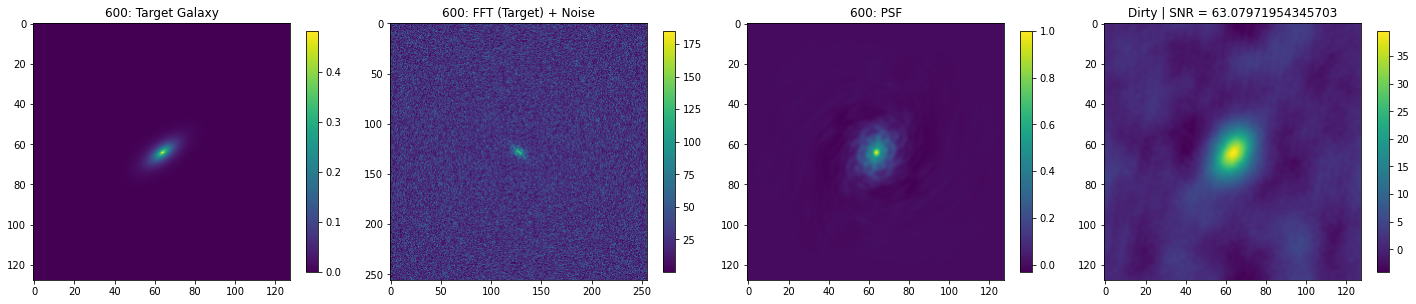

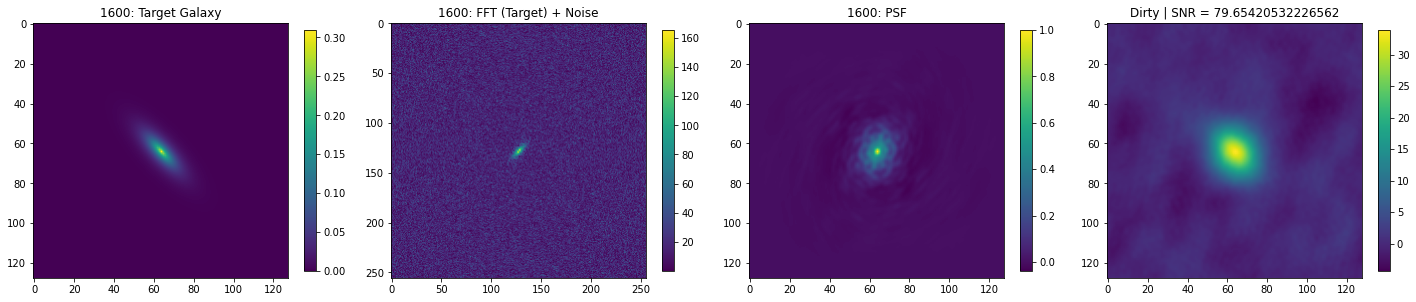

In [6]:
# Plot all galaxies for 1 SNR value
for i in [600, 1600]:
    SNR_ind = 3
    dirty = batch[0][i,SNR_ind,...]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    plt.figure(figsize=(20,20))
    plt.subplot(141)
    plt.imshow(np.squeeze(batch[1][i])); plt.colorbar(shrink=0.17); plt.title('{}: Target Galaxy'.format(i))
    plt.subplot(142)
    plt.imshow(np.squeeze(batch[4][i,SNR_ind,...])); plt.colorbar(shrink=0.17); plt.title('{}: FFT (Target) + Noise'.format(i))
    plt.subplot(143)
    plt.imshow(np.squeeze(batch[2][i])); plt.colorbar(shrink=0.17); plt.title('{}: PSF'.format(i))
    plt.subplot(144)
    plt.imshow(np.squeeze(dirty)); plt.colorbar(shrink=0.17); plt.title('Dirty | SNR = {}'.format(SNR))
    plt.tight_layout()
    plt.show()

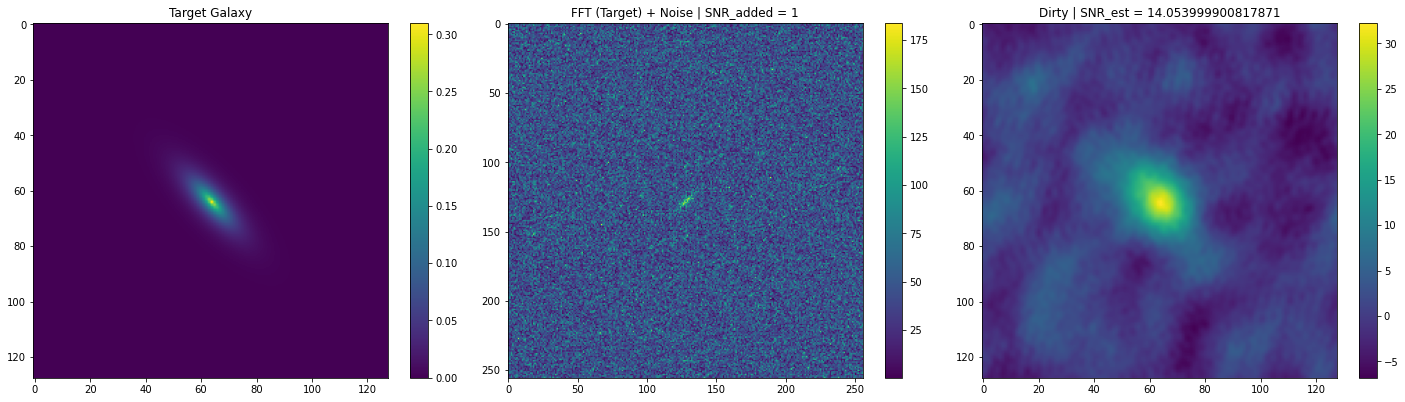

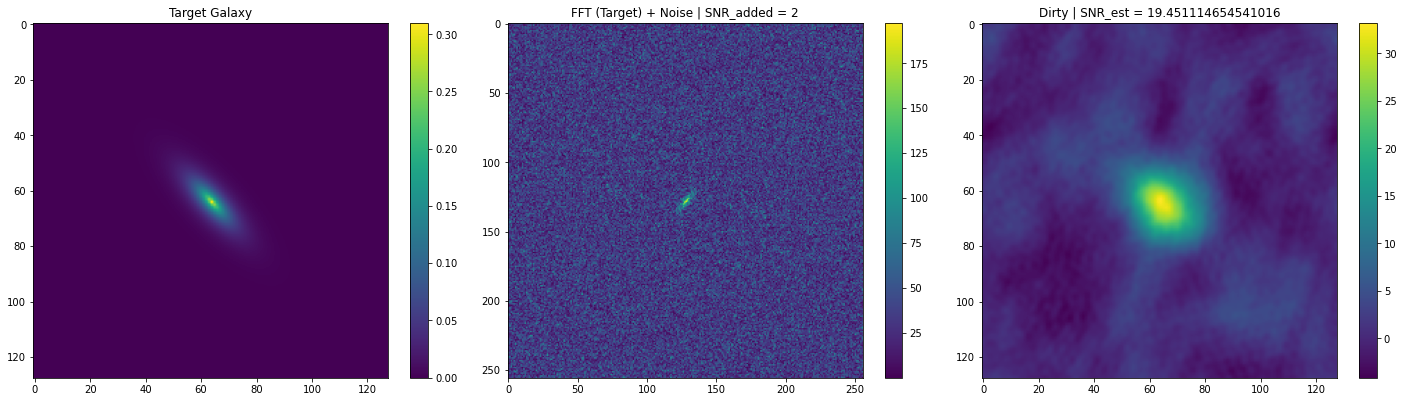

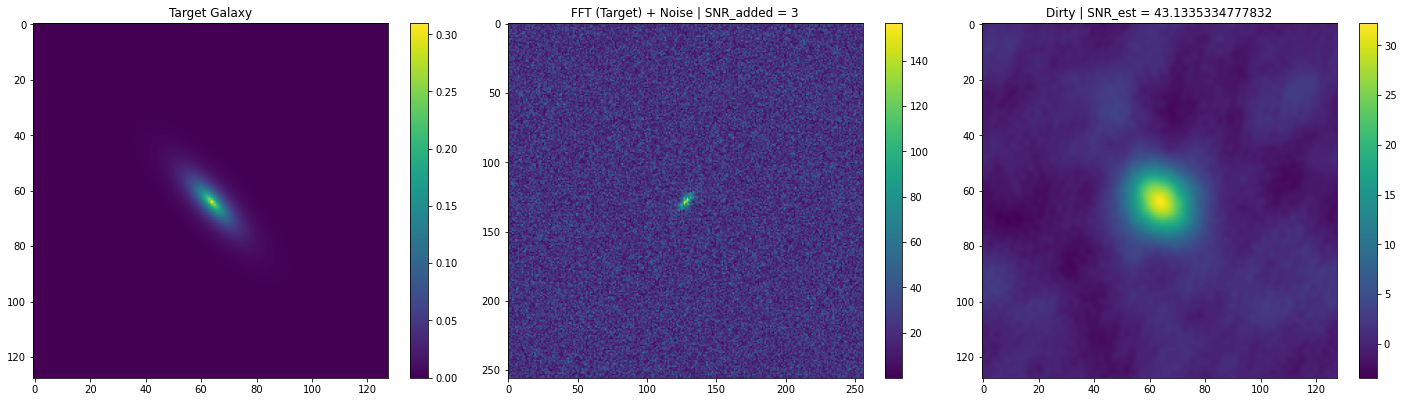

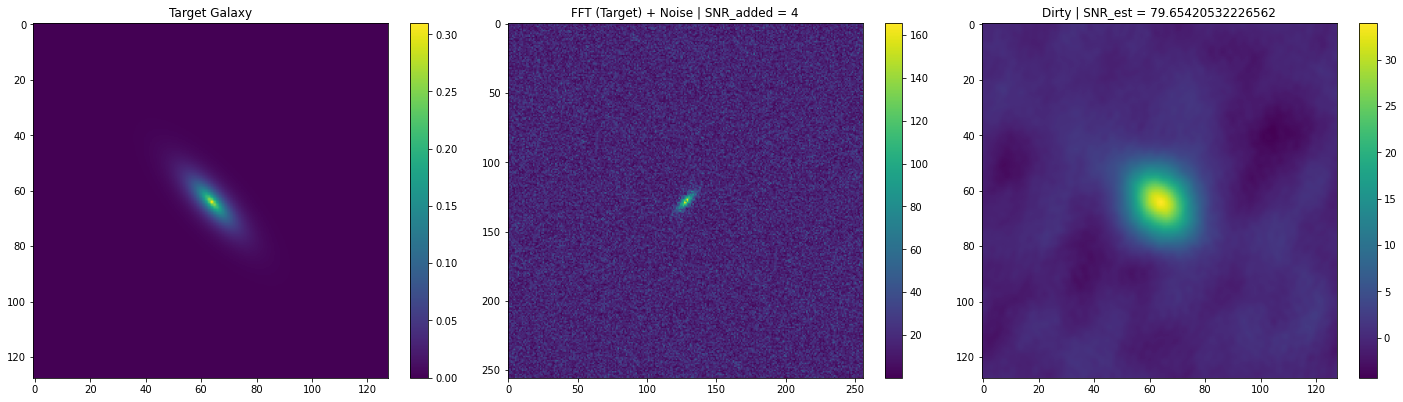

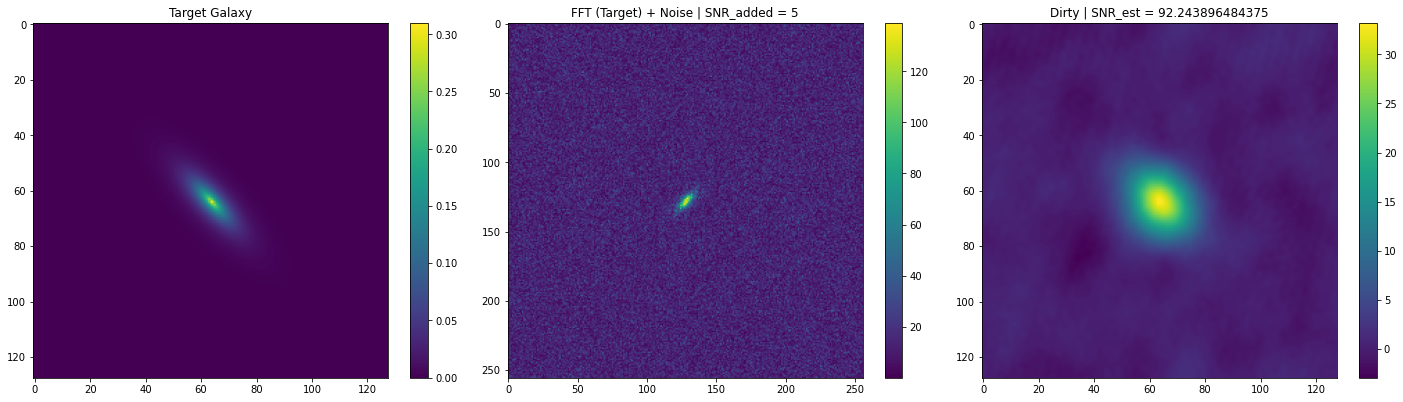

In [7]:
# Plot 1 galaxy for all SNR values
for j in range(batch[3].shape[1]):
    gal_ind = 1600
    dirty = batch[0][gal_ind,j,...]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(np.squeeze(batch[1][gal_ind])); plt.colorbar(shrink=0.25); plt.title('Target Galaxy')
    plt.subplot(132)
    plt.imshow(np.squeeze(batch[4][gal_ind,j,...])); plt.colorbar(shrink=0.25); plt.title('FFT (Target) + Noise | SNR_added = {}'.format(j+1))
    plt.subplot(133)
    plt.imshow(np.squeeze(dirty)); plt.colorbar(shrink=0.25); plt.title('Dirty | SNR_est = {}'.format(SNR))
    plt.tight_layout()
    plt.show()

### Load Trained U-Net Model

In [8]:
model_1 = tf.keras.models.load_model(path + 'UNet_Denoiser/Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}', compile=False)

# ADMM in TensorFlow

In [9]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )
     
    return tf.keras.backend.eval(cost_val).flatten()


# Spectral value
def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.float32) / 
            ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, sigma_noise, disp_step, n_iter, model):   
    
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.float32)
    z_0 = tf.cast(z_0, tf.float32)
    mu_0 = tf.cast(mu_0, tf.float32)
    rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.float32)      # max rho value
    eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1   
    
    # declare variables
    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.float32)  
    
    # ADMM parameters
    
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.float32)      

    # FISTA parameters
    
    t_k = tf.cast(1.0, tf.float32)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.float32)
      
    # square of spectral radius of convolution matrix
    
    sv = max_sv(psf, sigma, rho_k)           

    # The gradient descent step
    
    alpha = get_alpha(rho_k, sv, sigma) 
    
    # ADMM Loop 
    
    for k in range(n_iter): 
        
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)             # Project negative values
        
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1               
    
        ## Denoising sub-step
     
        z_k1 = x_k1 + (mu_k / rho_k)

        # U-Net Denoising
        
        z_k1 = tf.expand_dims(tf.expand_dims(z_k1, axis=0), axis=-1)
        z_k1 = tf.cast(tf.squeeze(model(z_k1)), tf.float32) #/ (tf.reduce_max(x_k1)/tf.reduce_max(z_k1))
        
        ## mu update
        
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
               
        ## Cost
        
        cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))              
        
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_input_tf.get_shape().as_list()[0], tf.float32) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)            
        
        # Update all variables
        
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)
        
        # Reconstruction
        
        final_im = x_k          
               
        # Compute NMSE
        
        nmse_arr[k] = nmse(gal_target_tf, final_im)     
        
        # Check if optimal reconstruction is achieved
        
        if nmse_arr[k]==np.min(nmse_arr):
            x_opt = final_im     
        
        # Display plots
        
        if (k+1)%disp_step==0 and k!=0:
            plot_utils.plot_iter(final_im, gal_target, y, k+1)
          
        
    return x_opt, cost, nmse_arr

### Run ADMM



 Gal_ind = 1600 | SNR_ind = 0




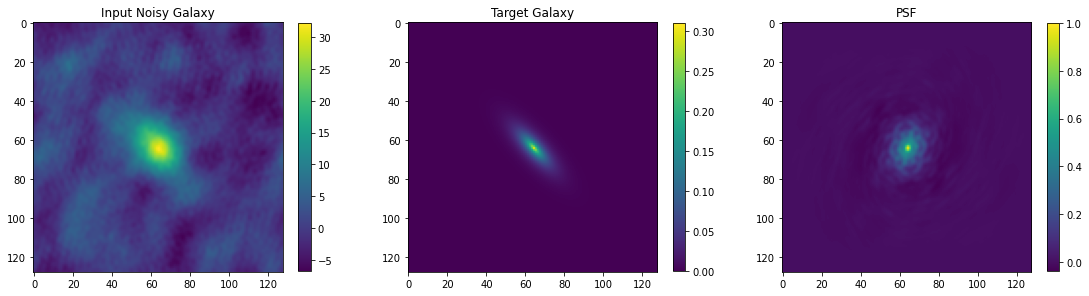

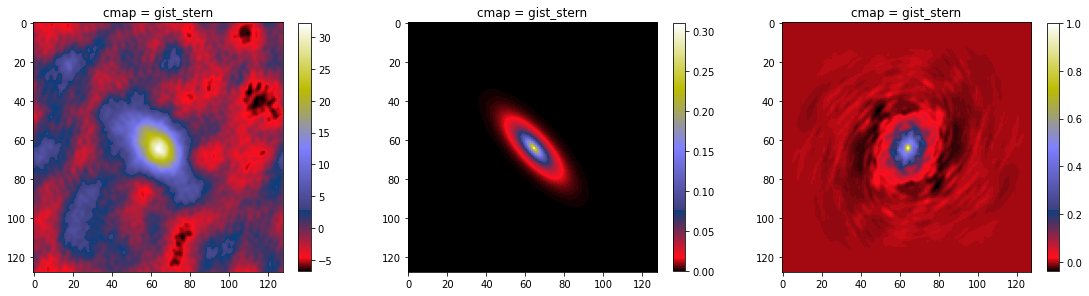

SNR (in Direct Space) = 14.054
Noise Std (in Direct Space) = 2.2937286
PSF max. pixel value =  1.0


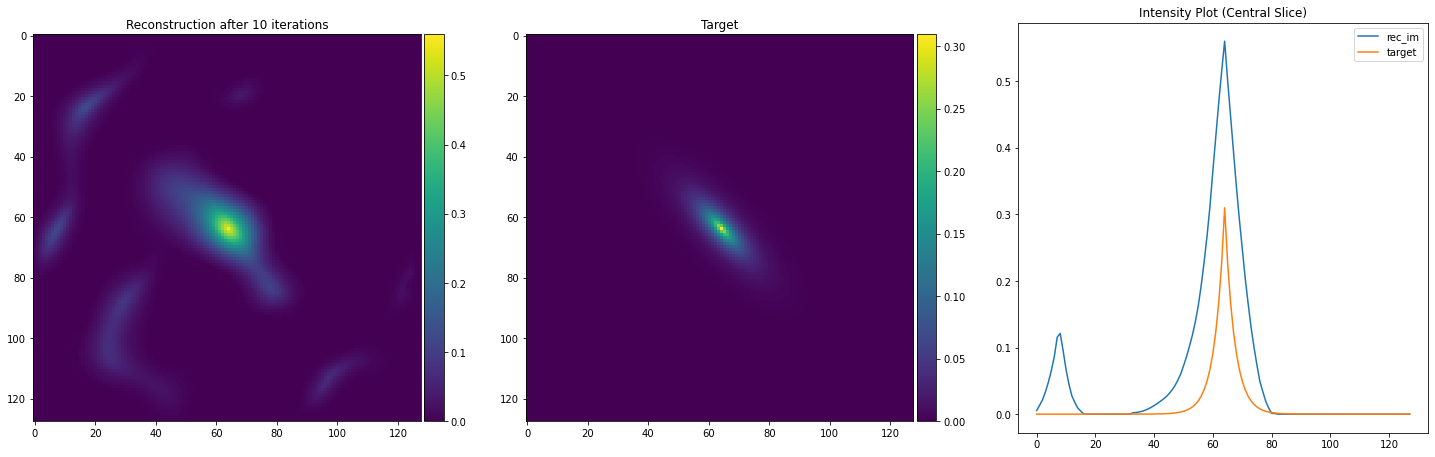

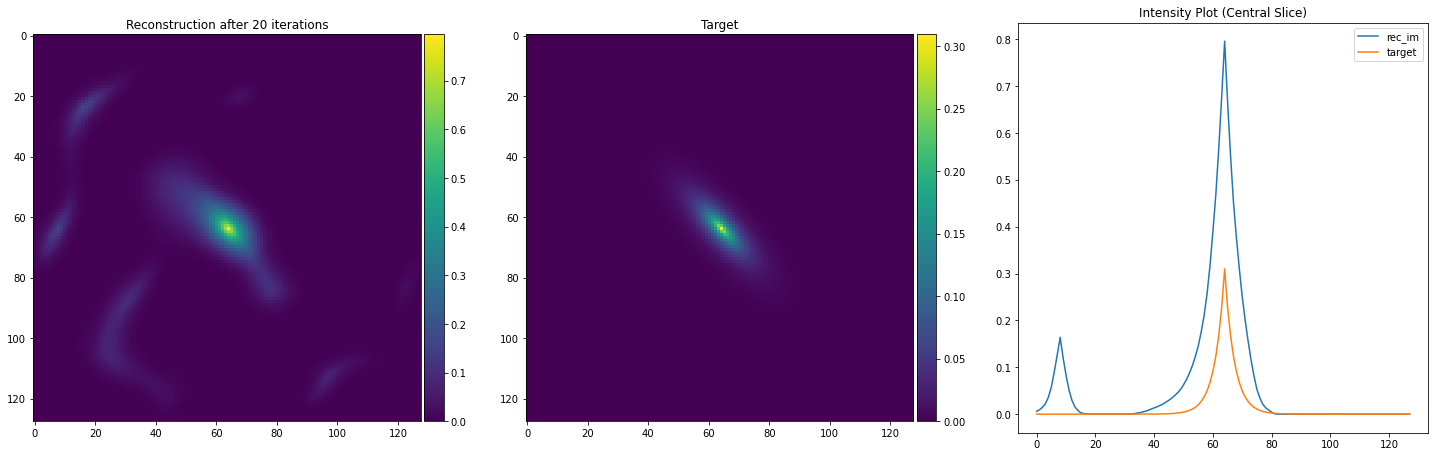

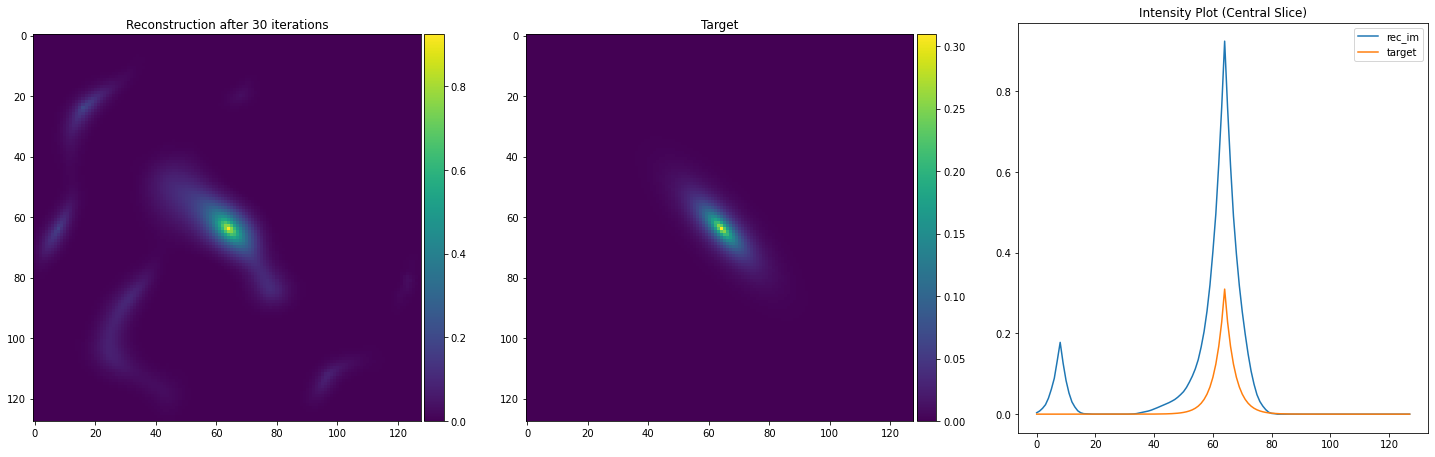

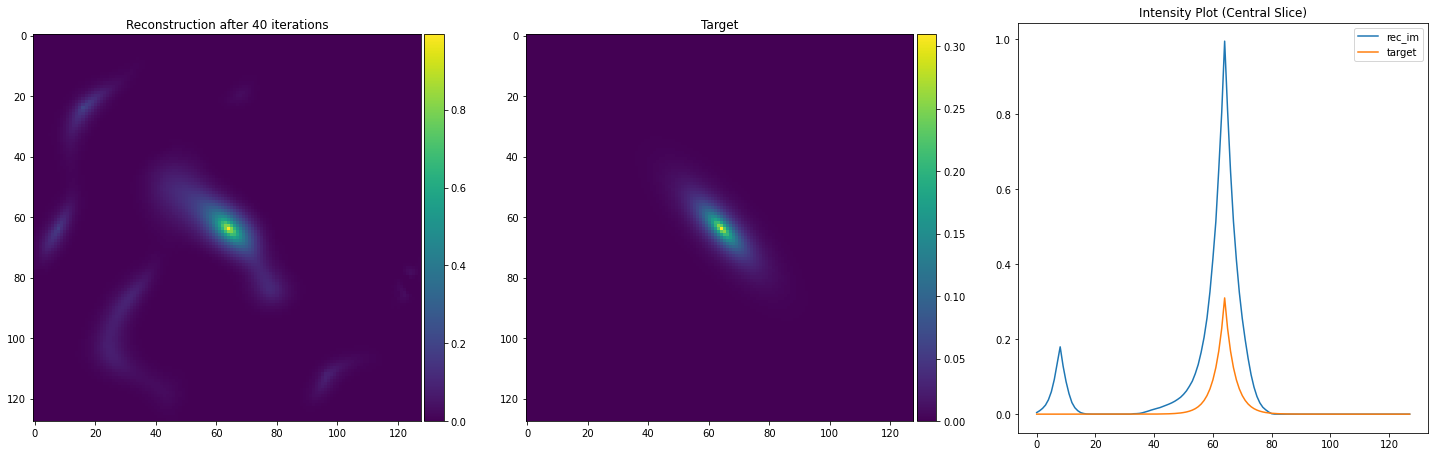

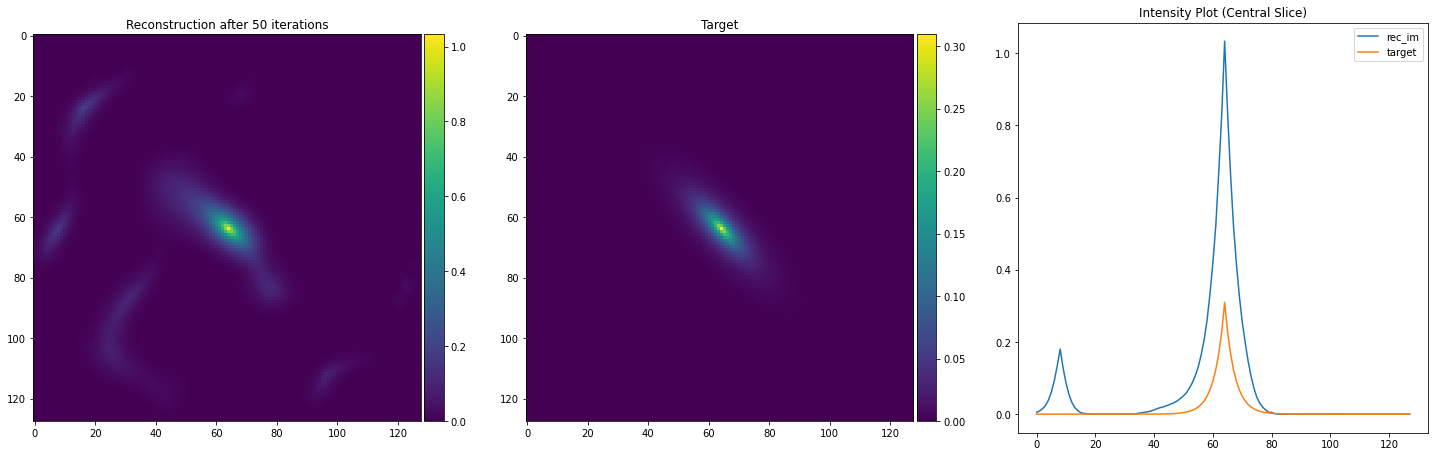

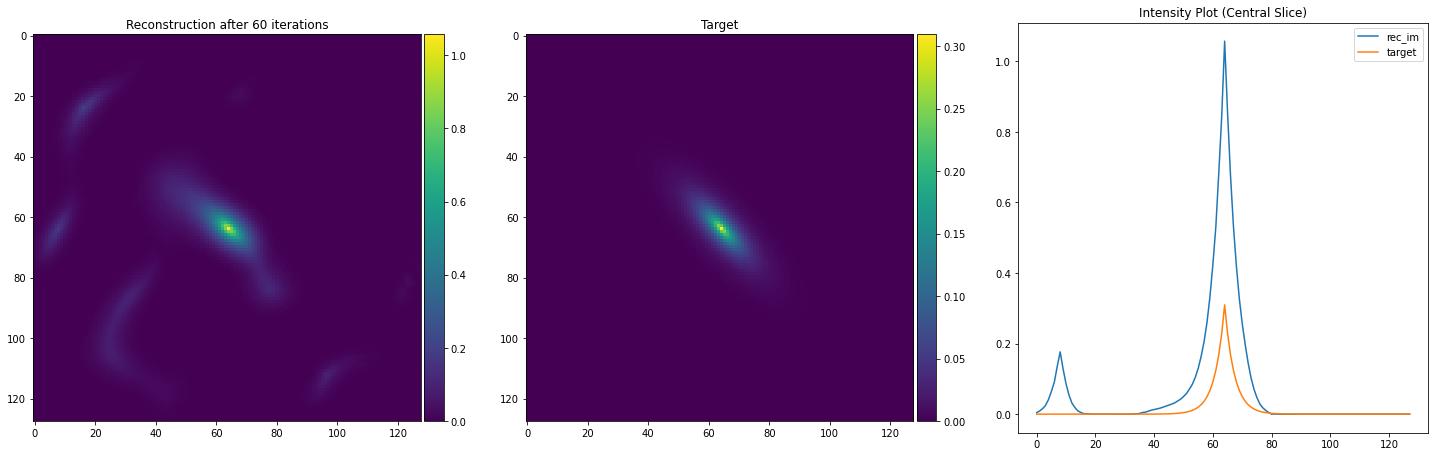

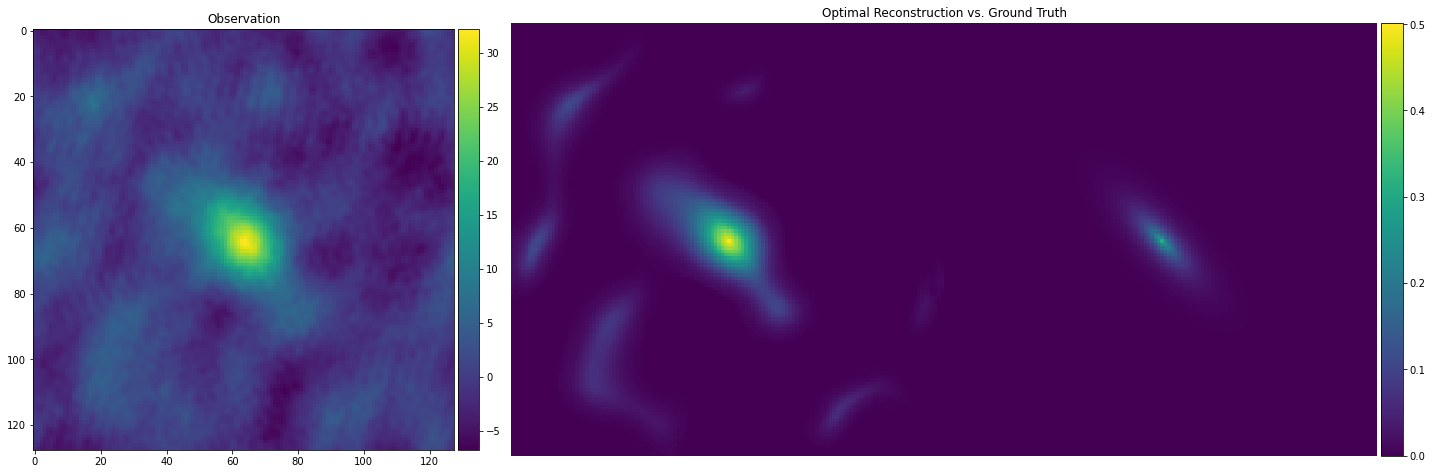

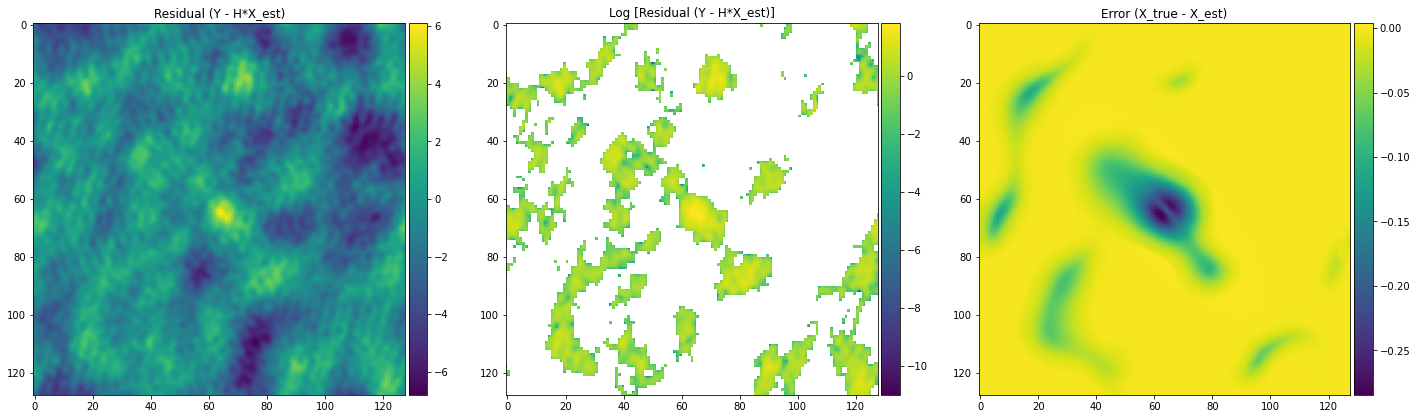

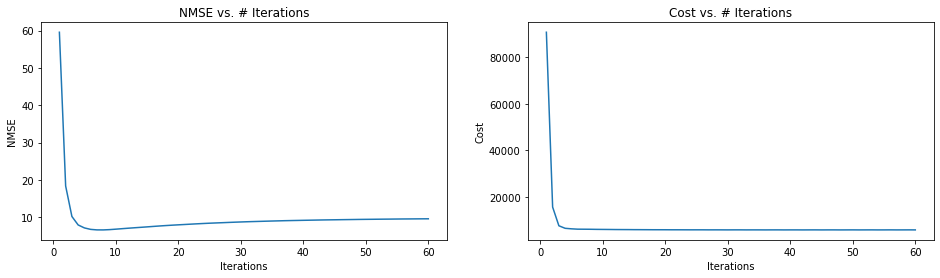


Minimum NMSE = 6.571516036987305 (at [8] iterations)
Minimum Cost = 5967.24658203125 (at [48] iterations)


 Gal_ind = 1600 | SNR_ind = 1




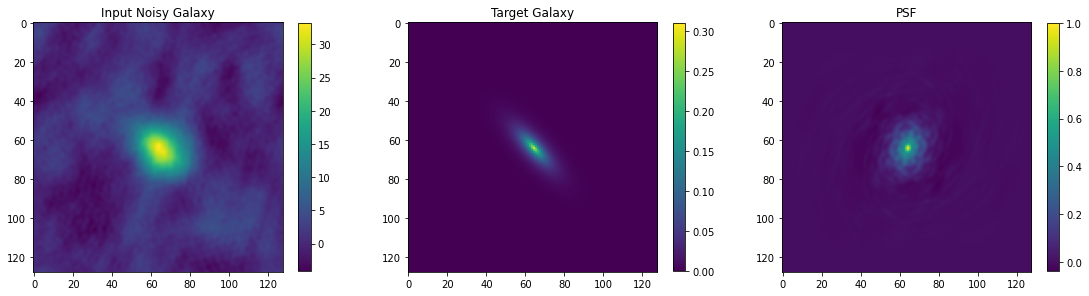

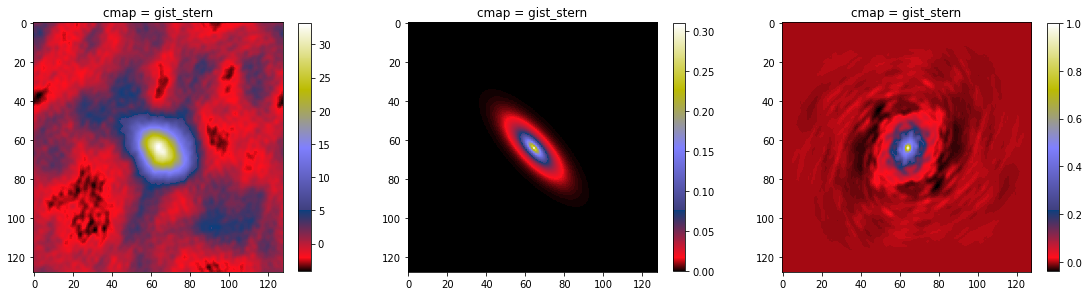

SNR (in Direct Space) = 19.451115
Noise Std (in Direct Space) = 1.7070682
PSF max. pixel value =  1.0


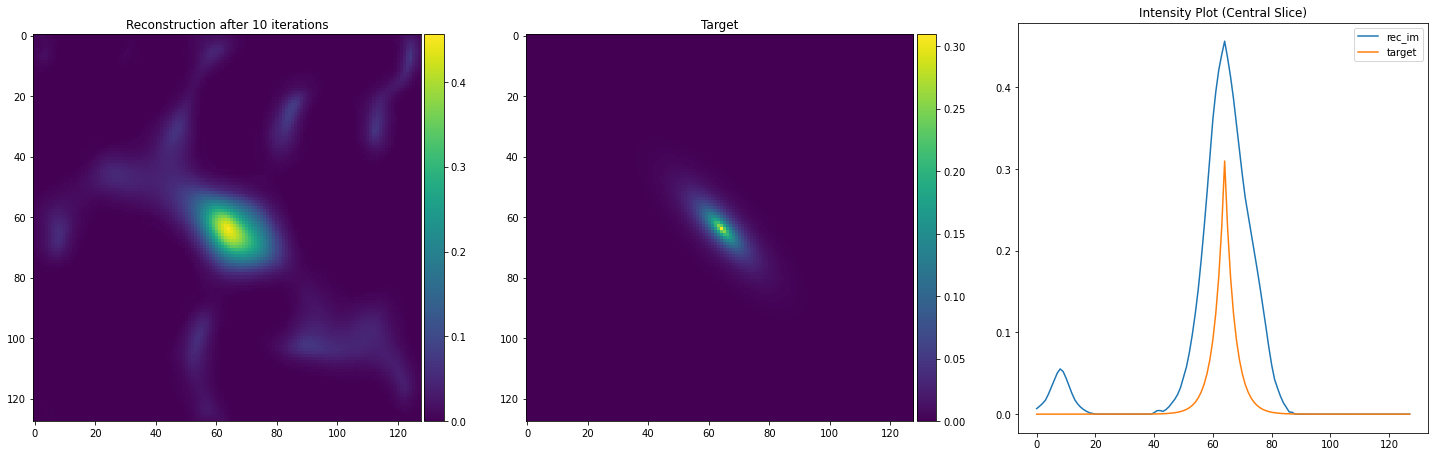

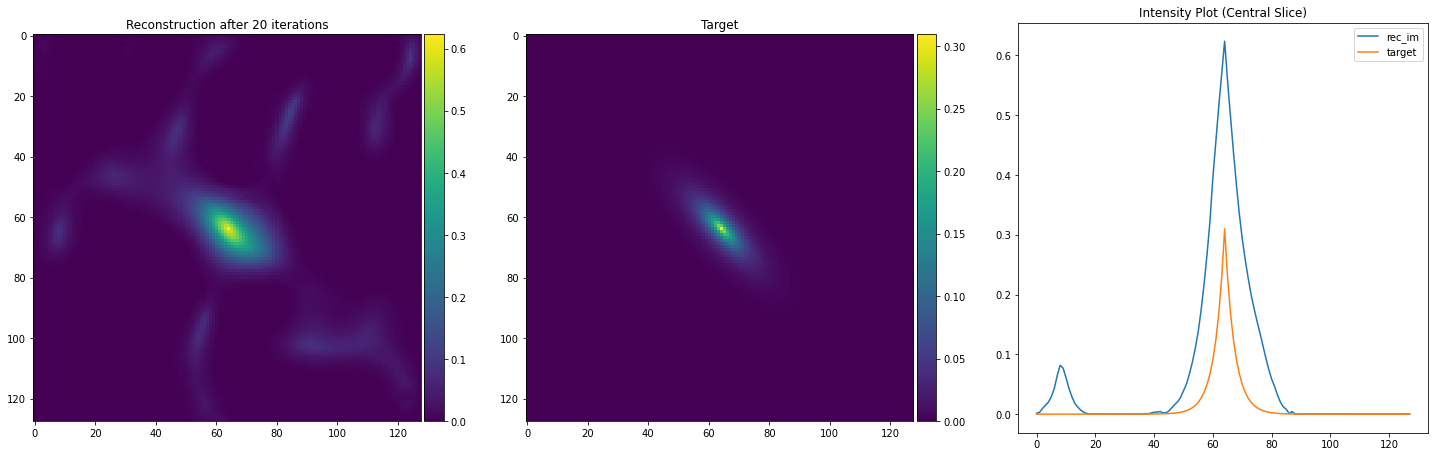

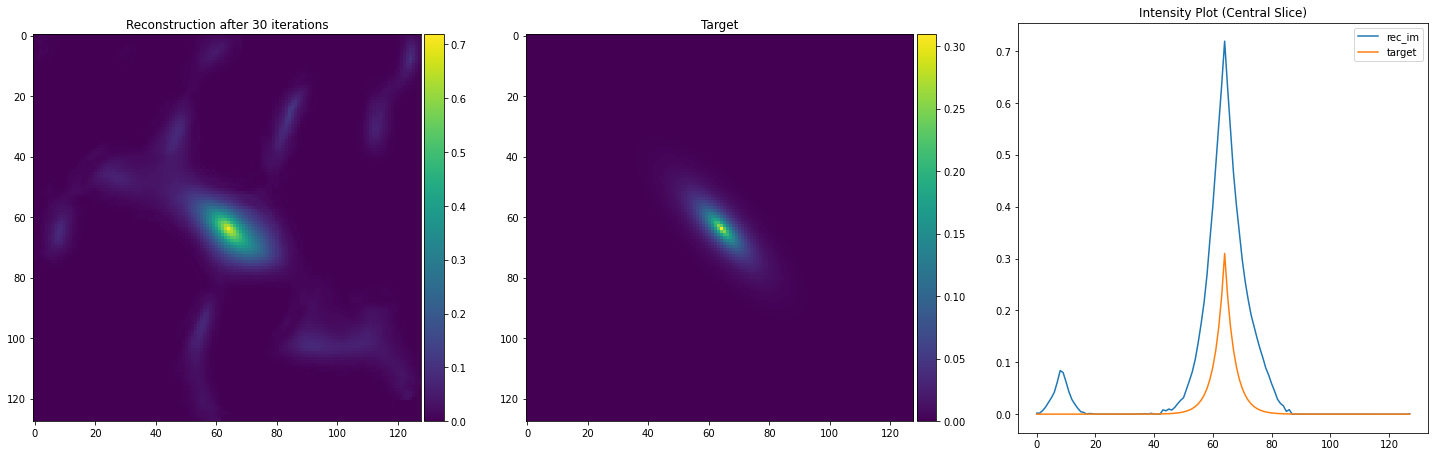

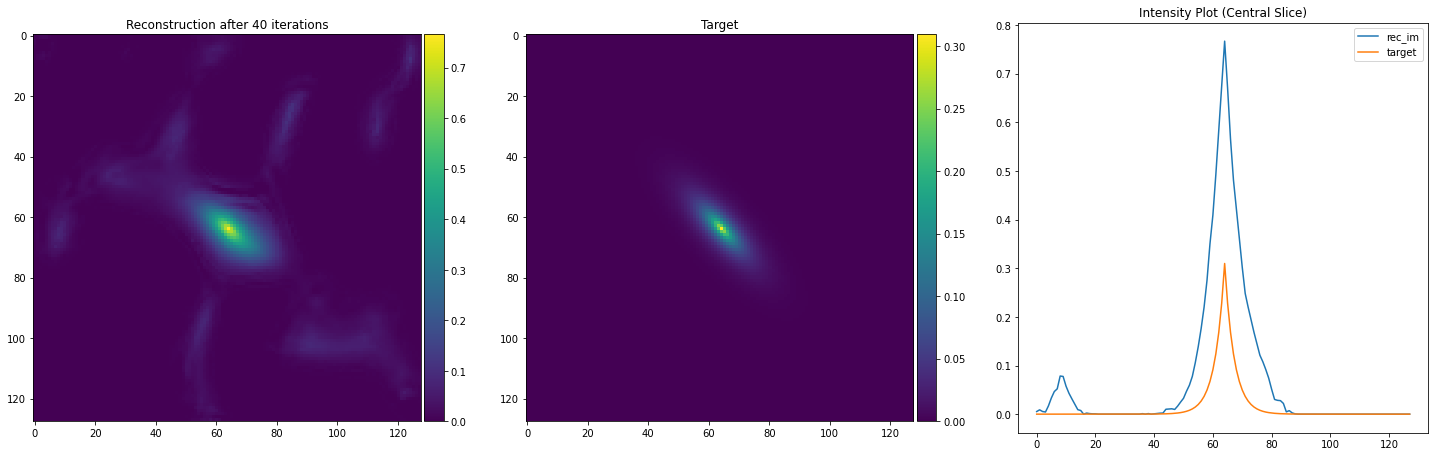

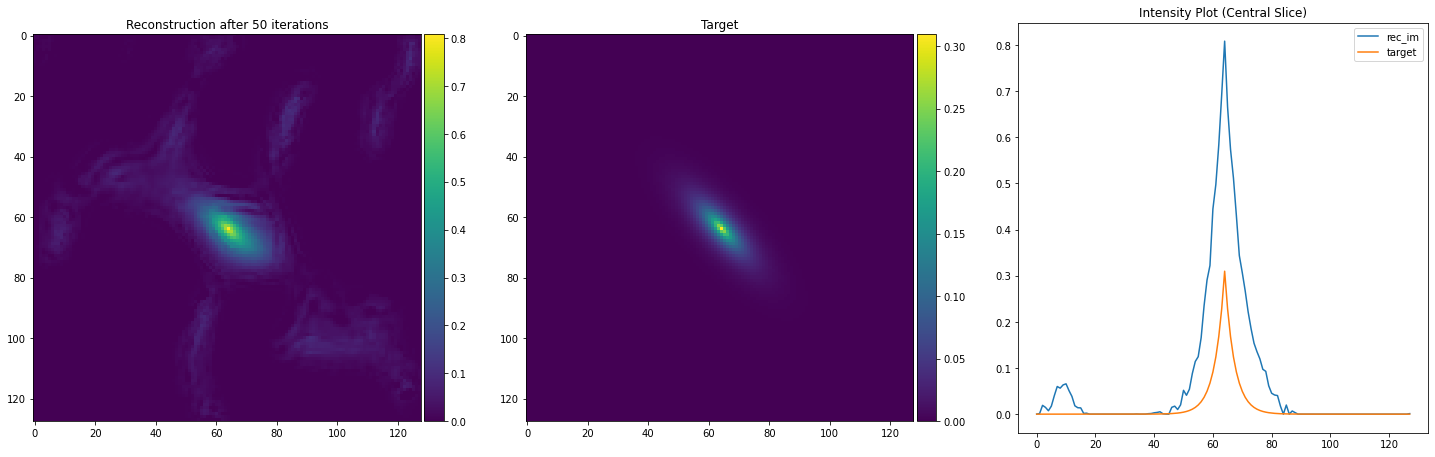

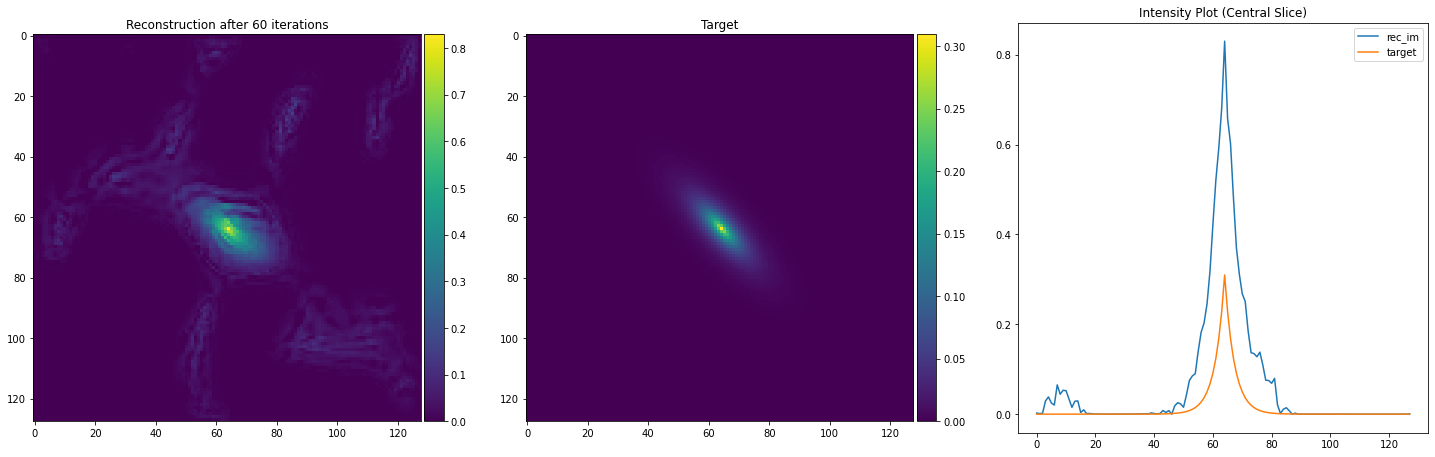

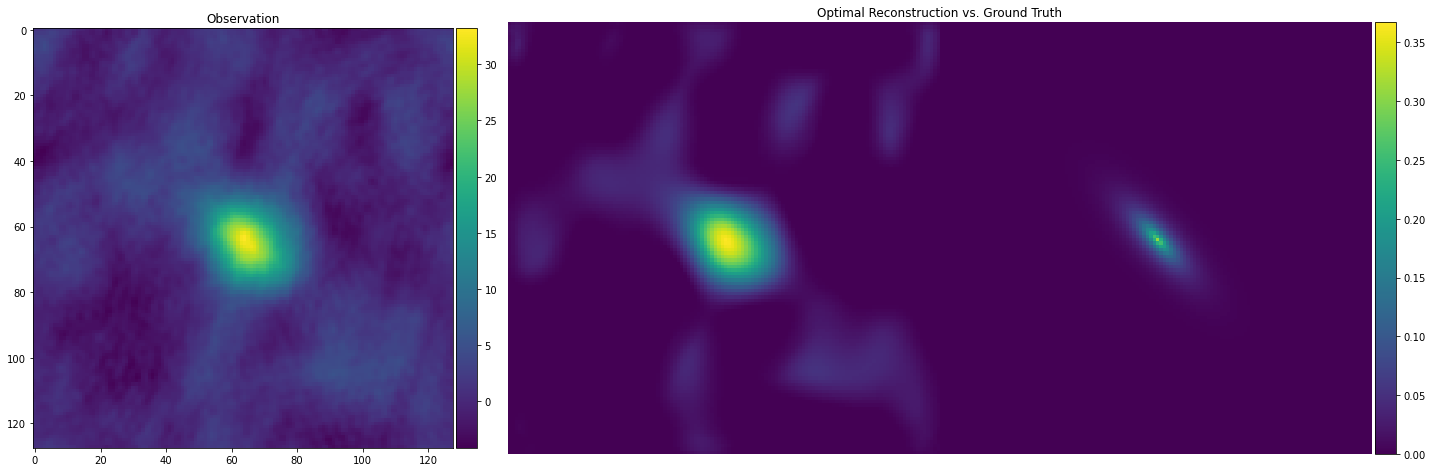

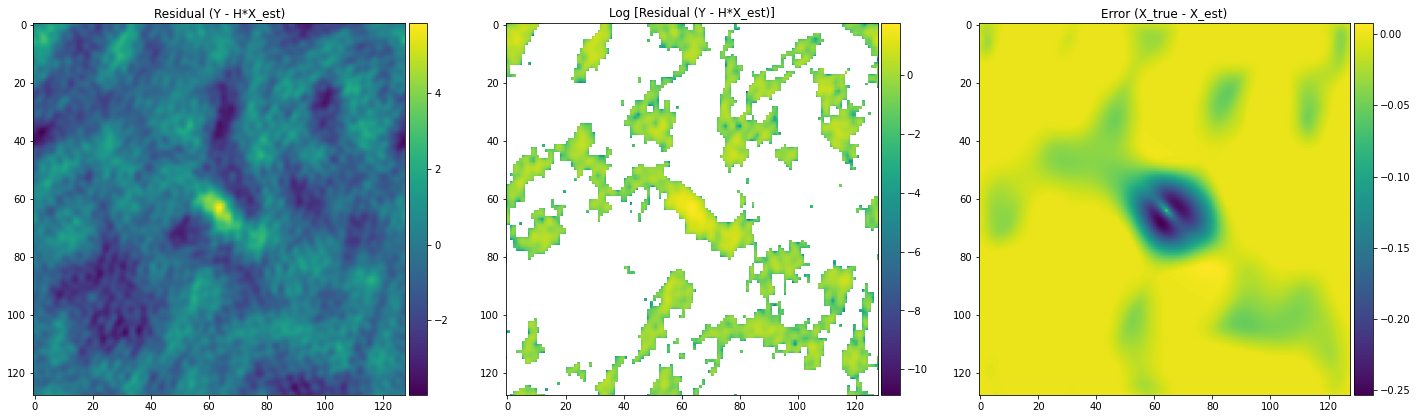

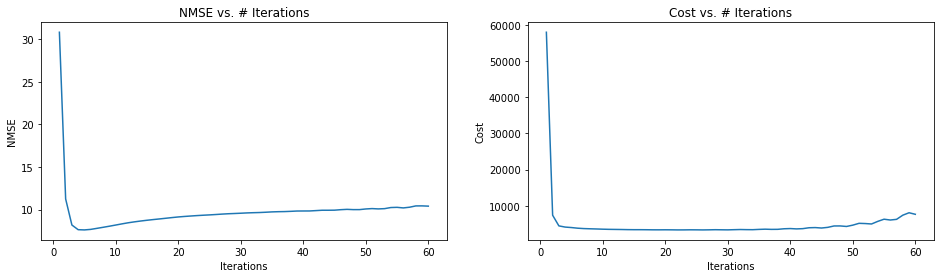


Minimum NMSE = 7.602485179901123 (at [5] iterations)
Minimum Cost = 3304.273681640625 (at [26] iterations)


 Gal_ind = 1600 | SNR_ind = 2




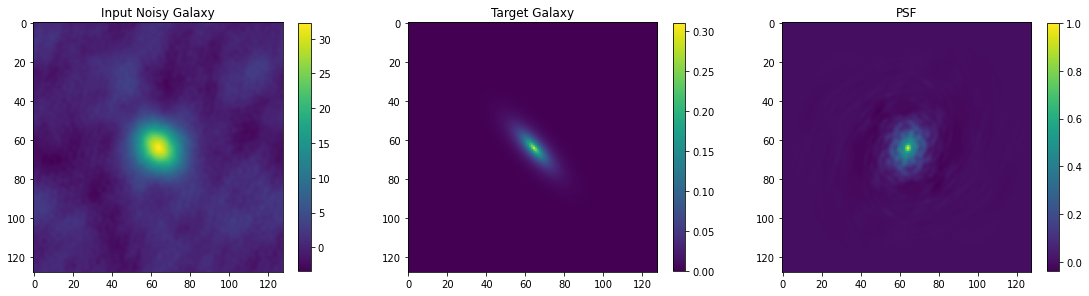

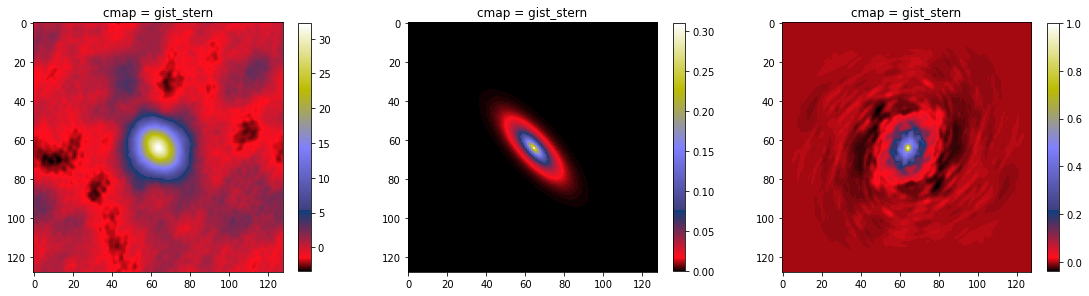

SNR (in Direct Space) = 43.133533
Noise Std (in Direct Space) = 0.7474457
PSF max. pixel value =  1.0


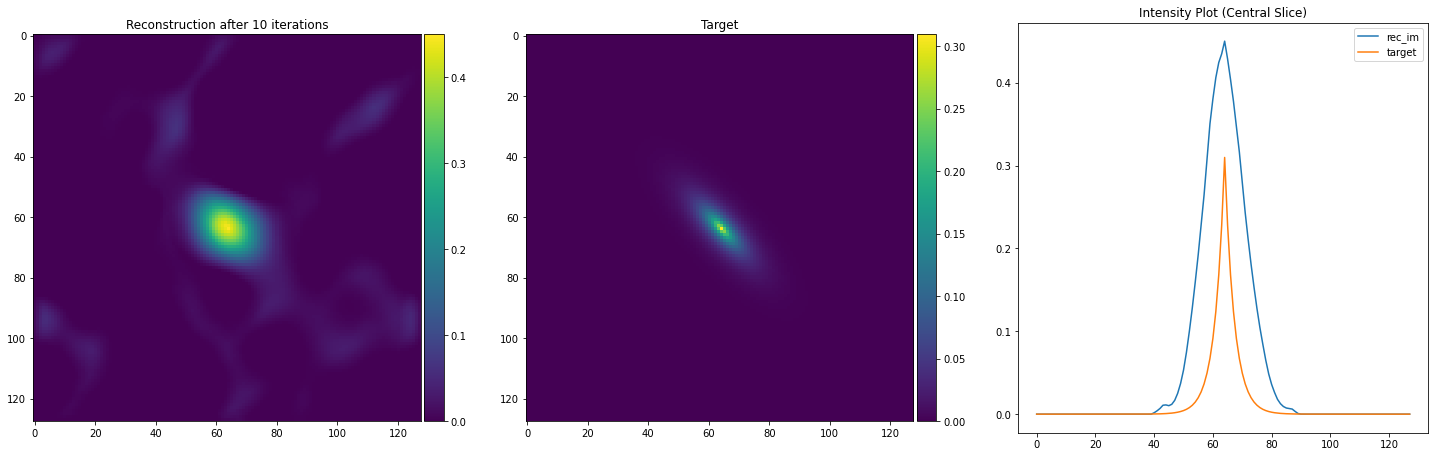

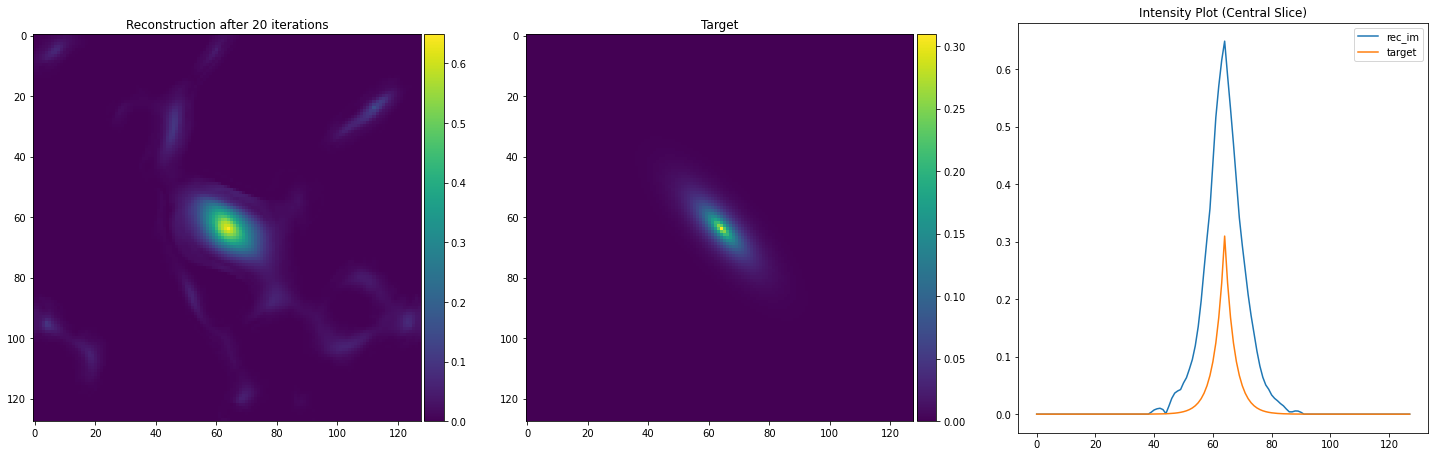

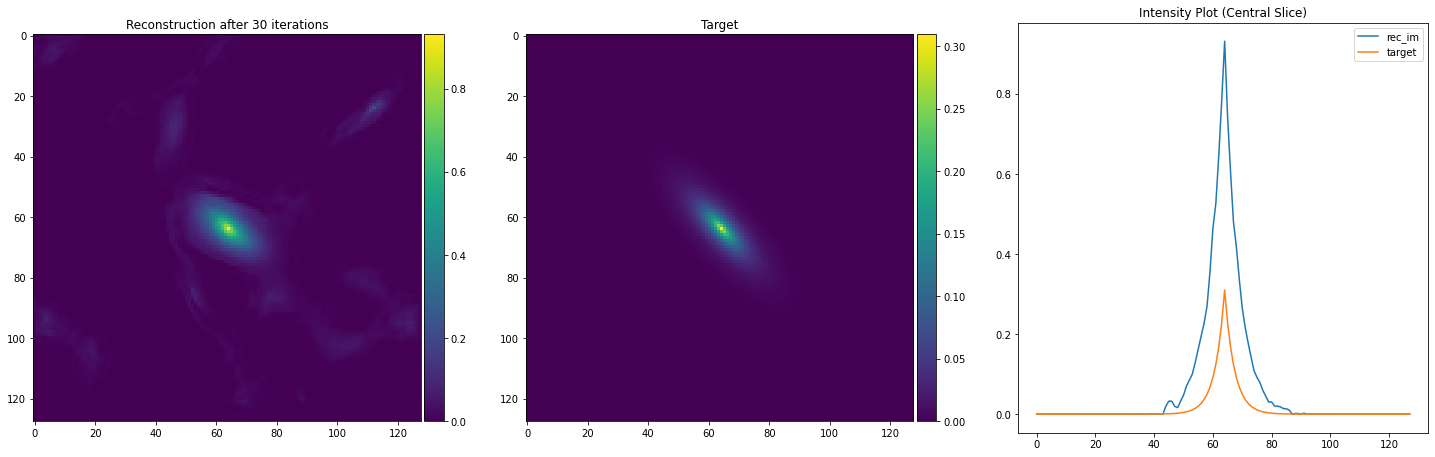

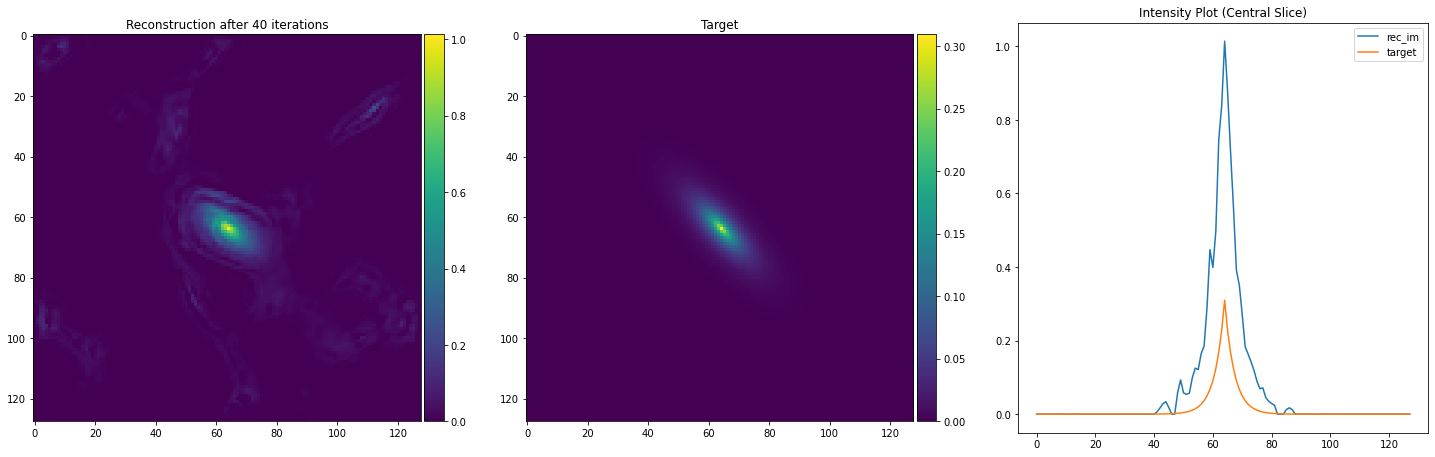

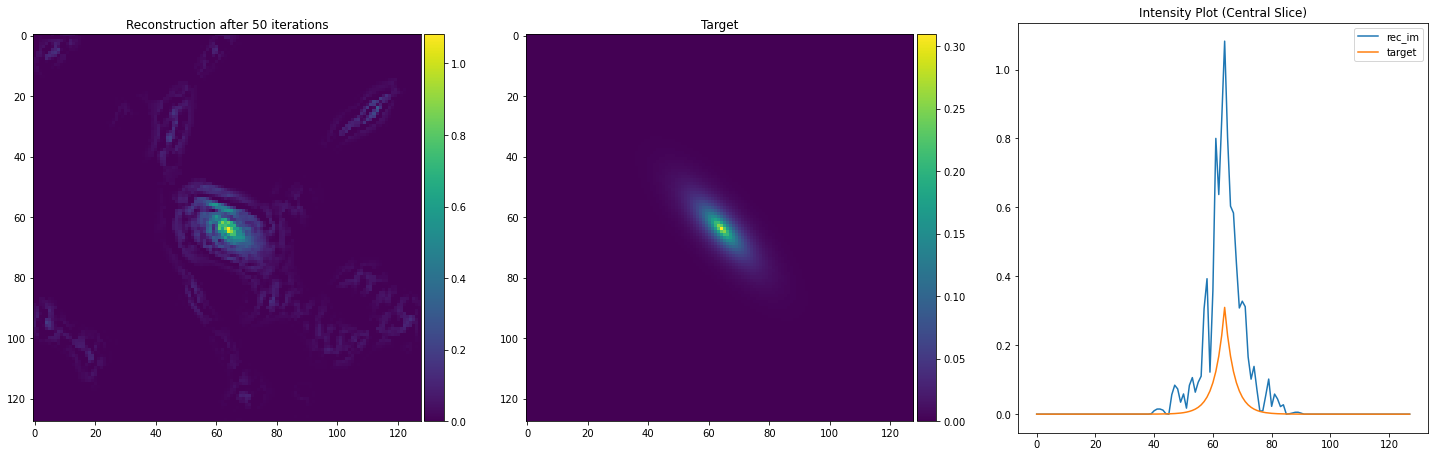

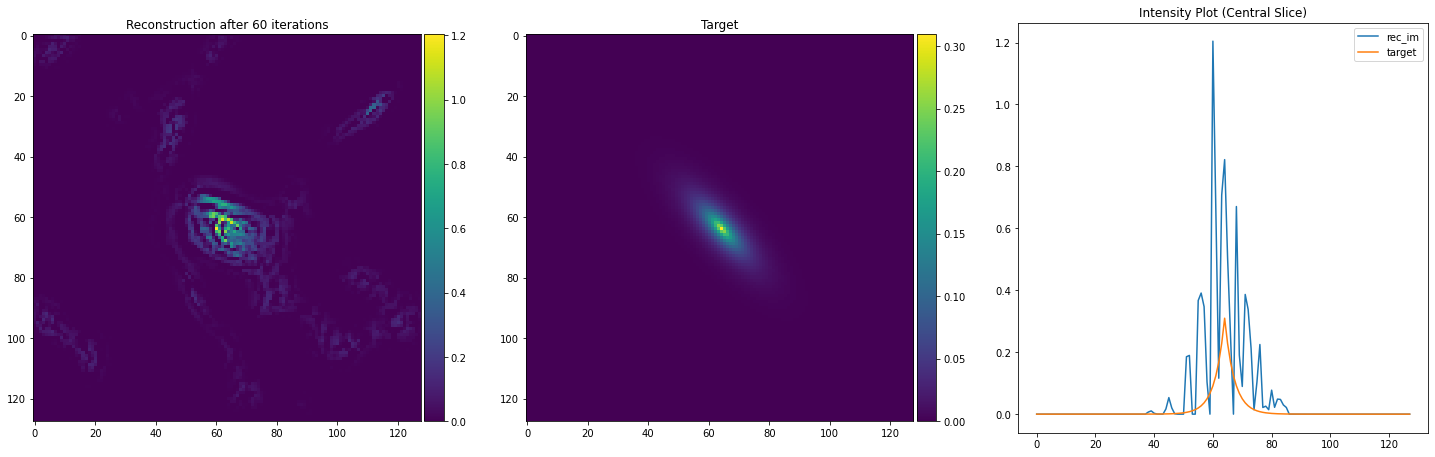

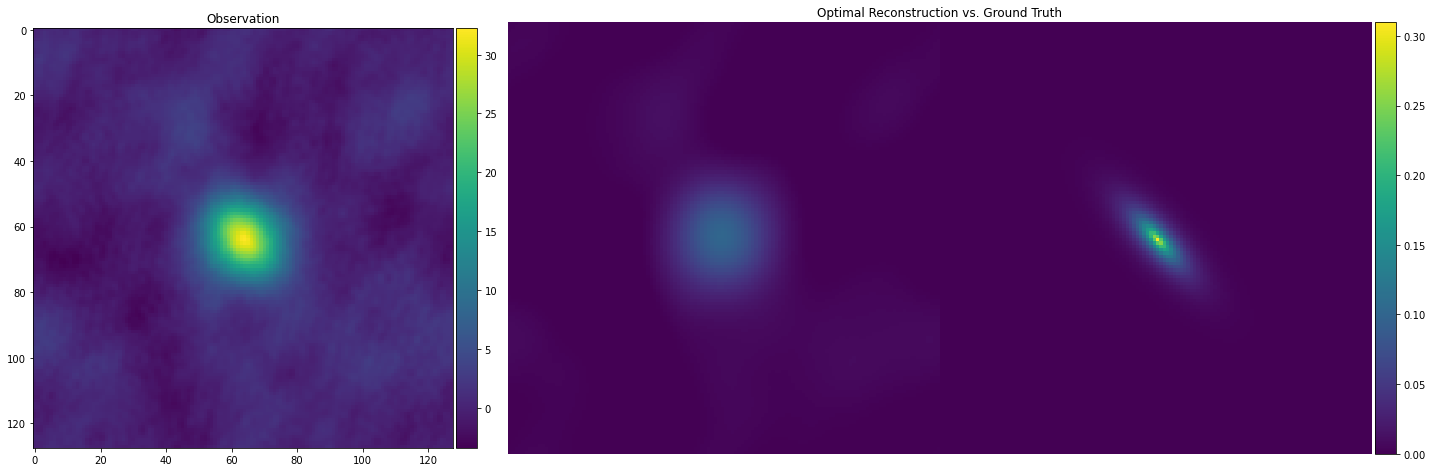

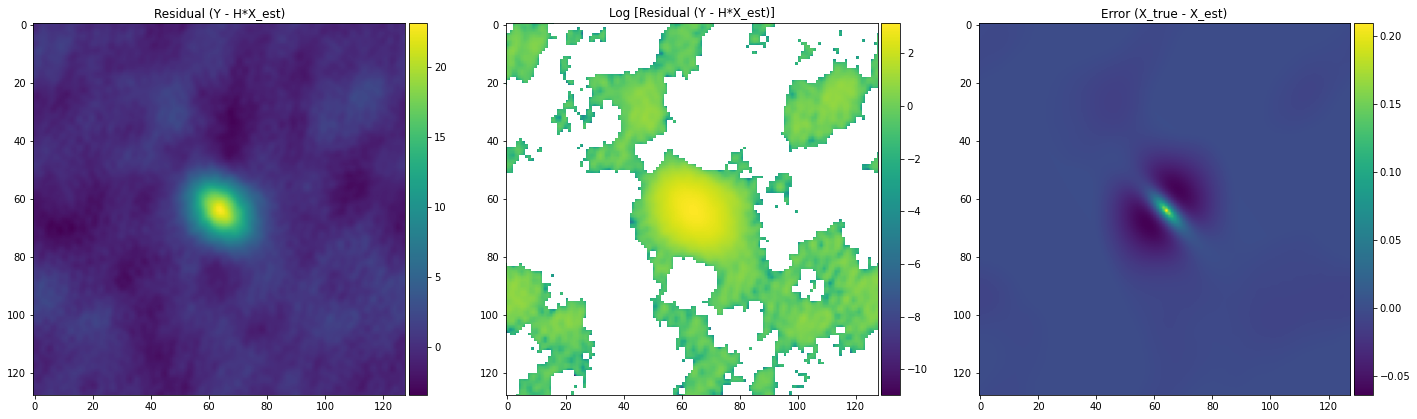

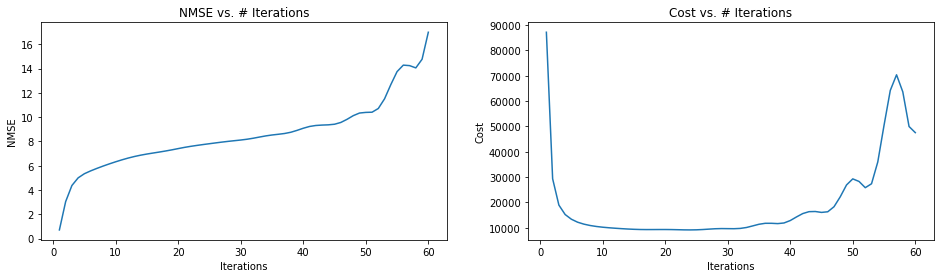


Minimum NMSE = 0.7081499695777893 (at [1] iterations)
Minimum Cost = 9163.7255859375 (at [24] iterations)


 Gal_ind = 1600 | SNR_ind = 3




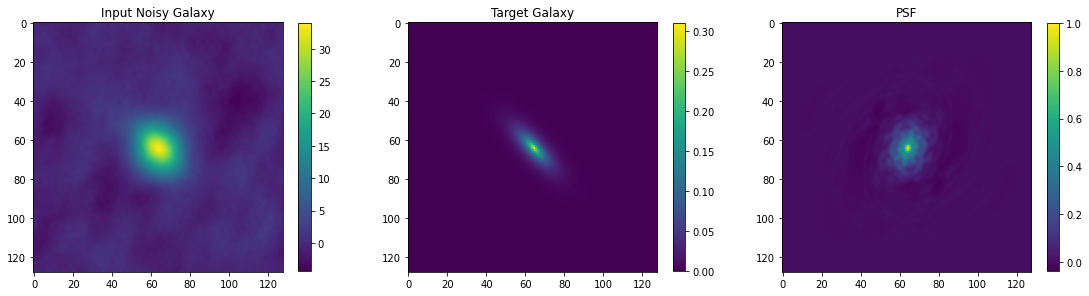

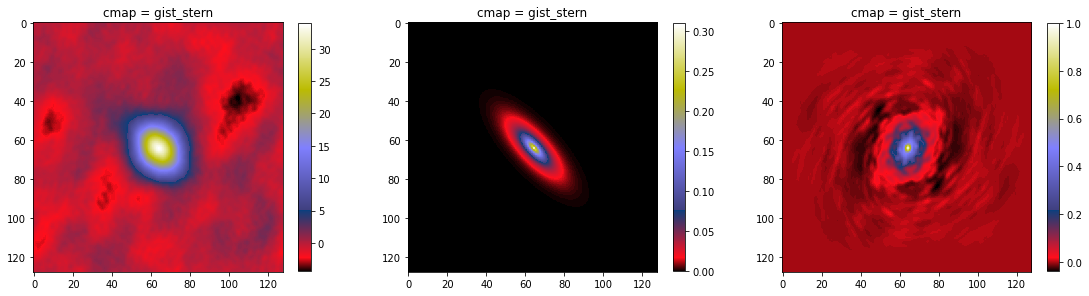

SNR (in Direct Space) = 79.654205
Noise Std (in Direct Space) = 0.4261692
PSF max. pixel value =  1.0


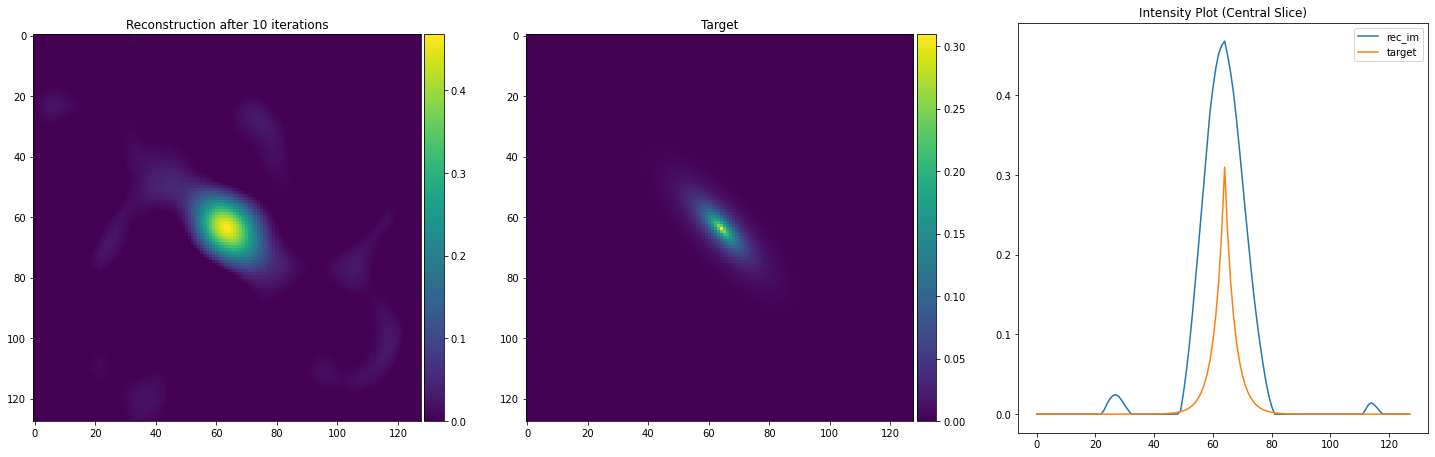

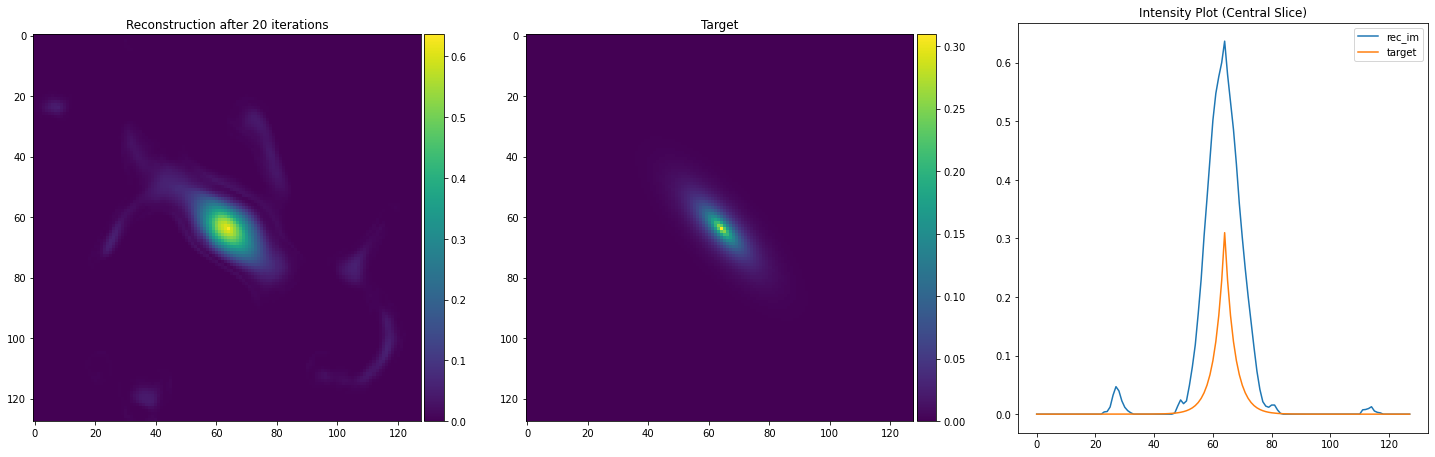

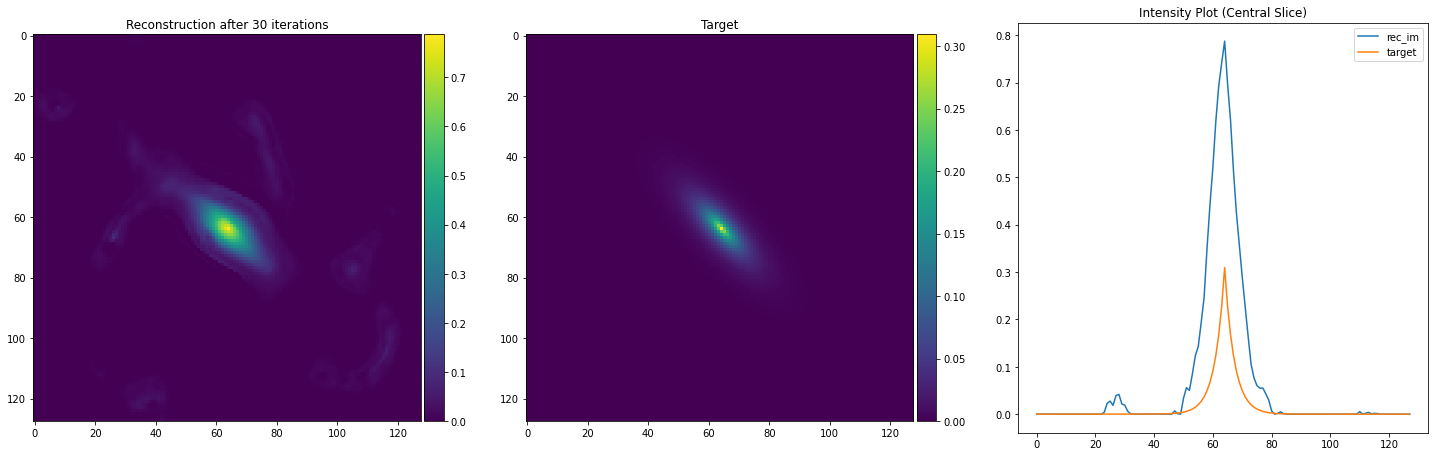

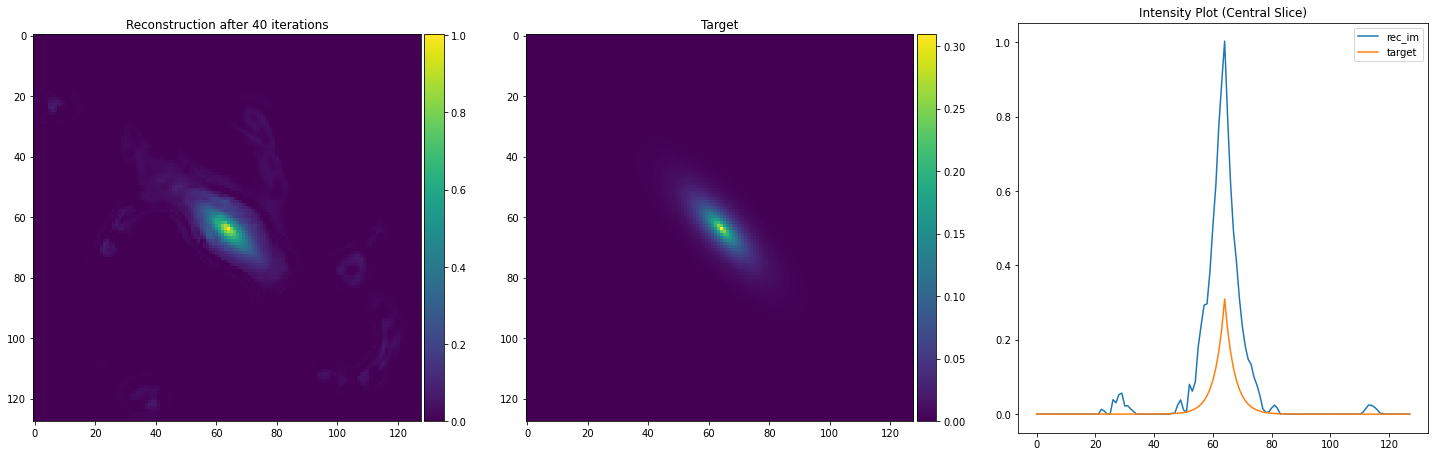

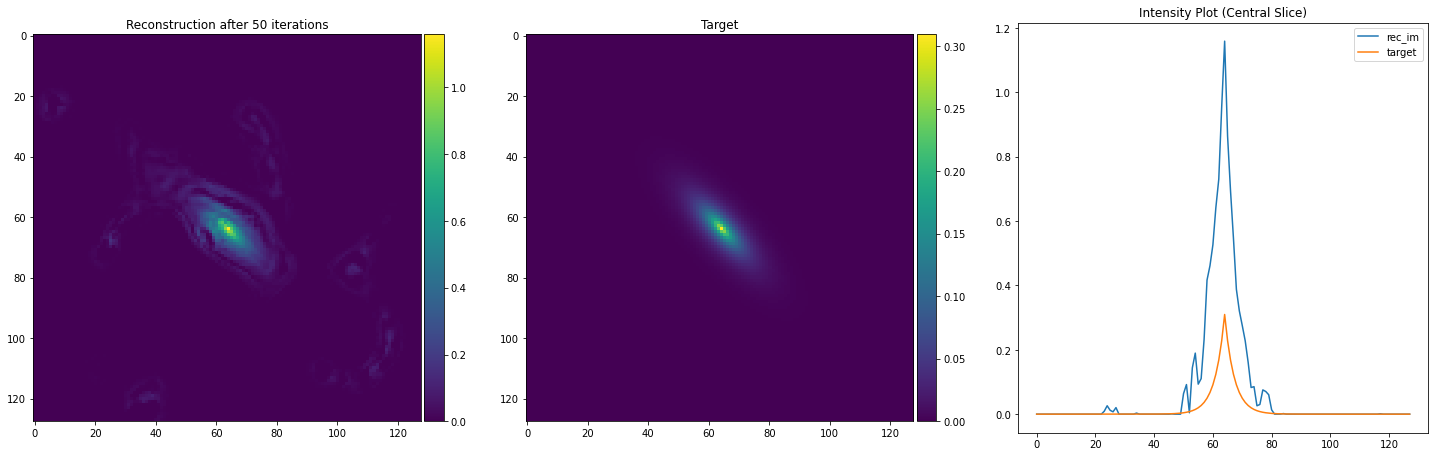

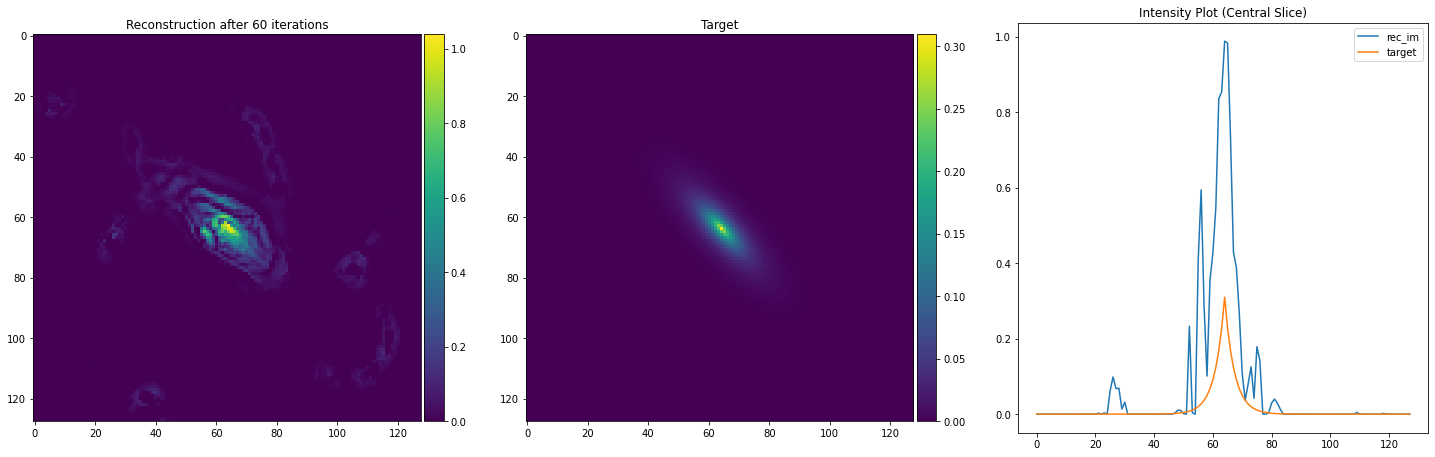

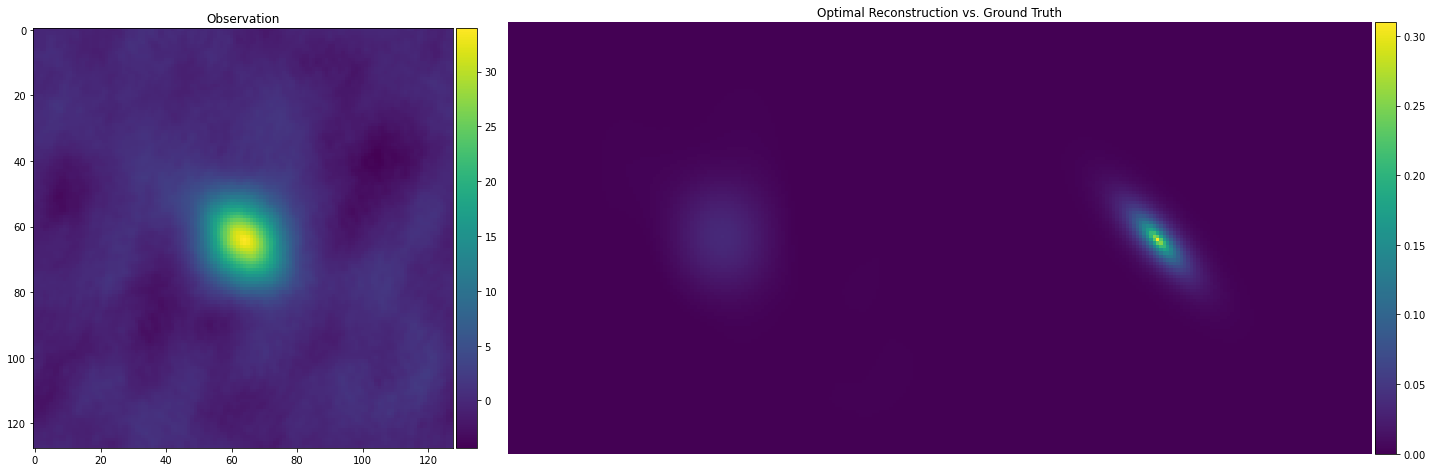

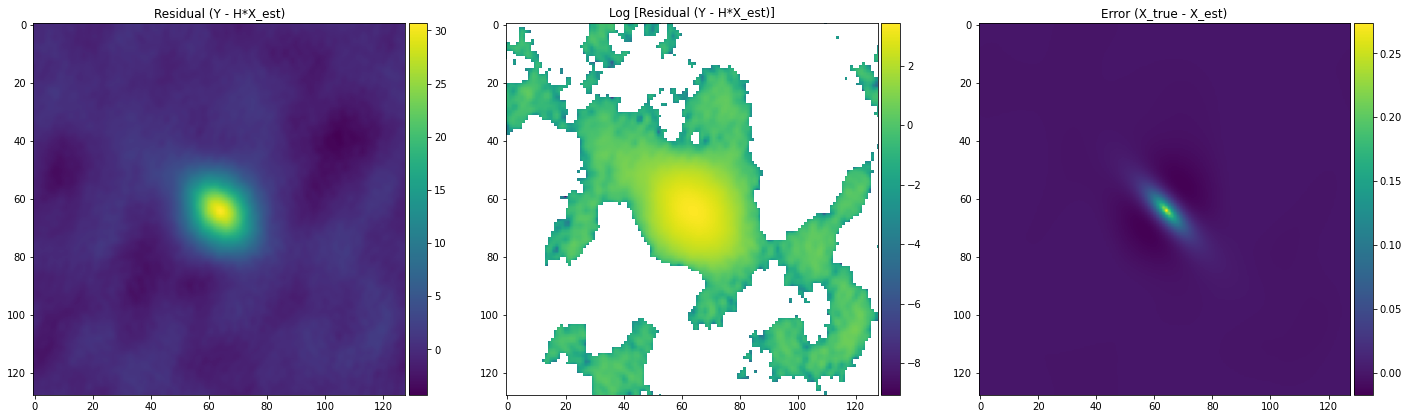

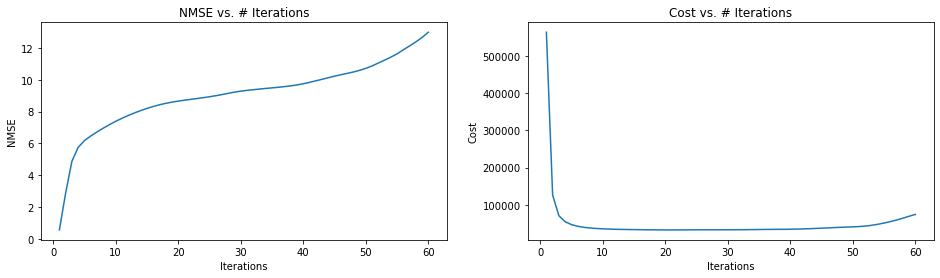


Minimum NMSE = 0.5553224682807922 (at [1] iterations)
Minimum Cost = 33007.625 (at [21] iterations)


 Gal_ind = 1600 | SNR_ind = 4




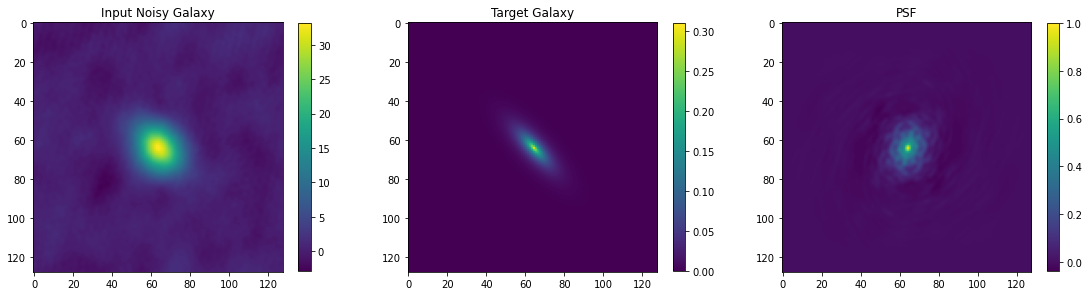

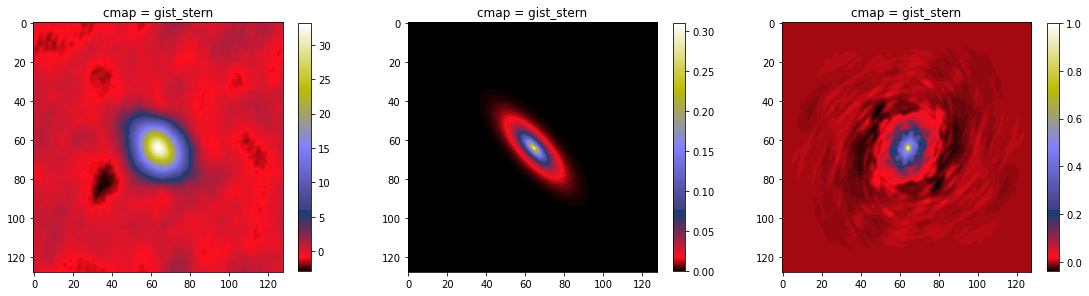

SNR (in Direct Space) = 92.2439
Noise Std (in Direct Space) = 0.3596554
PSF max. pixel value =  1.0


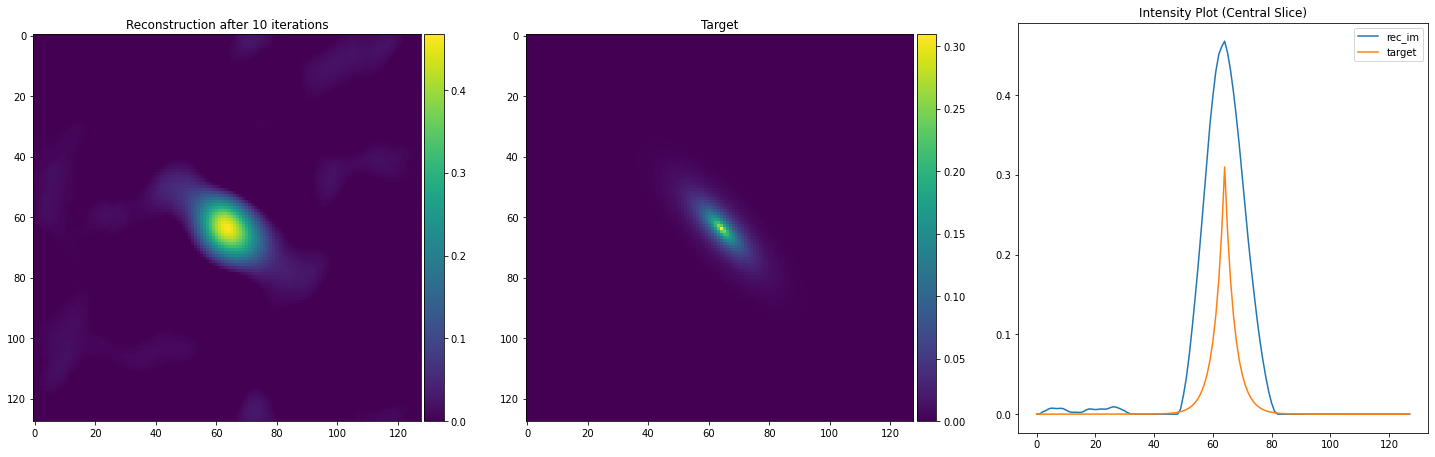

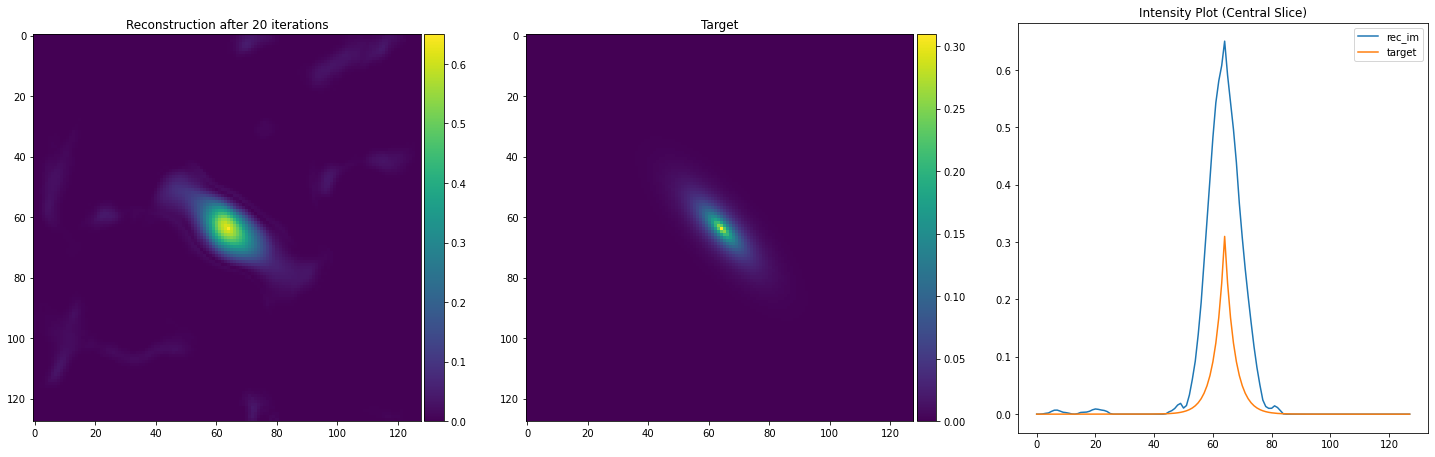

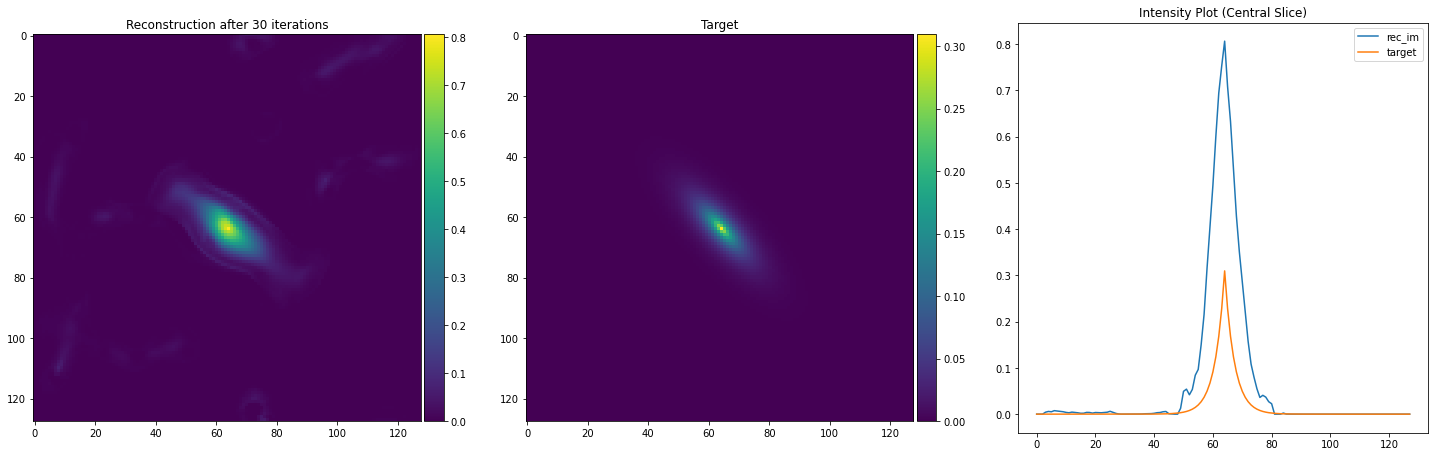

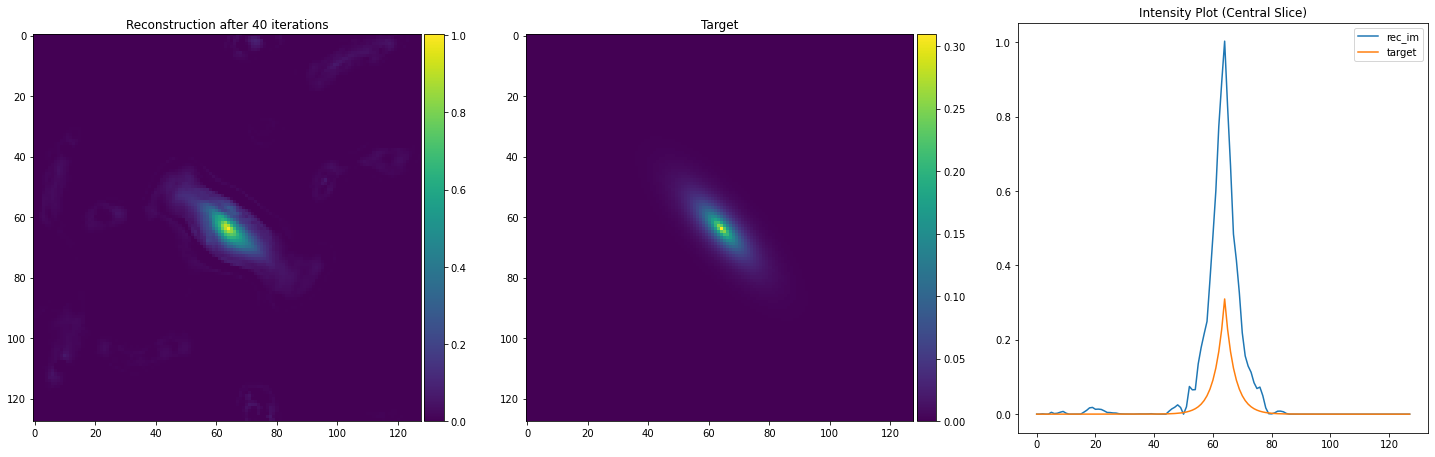

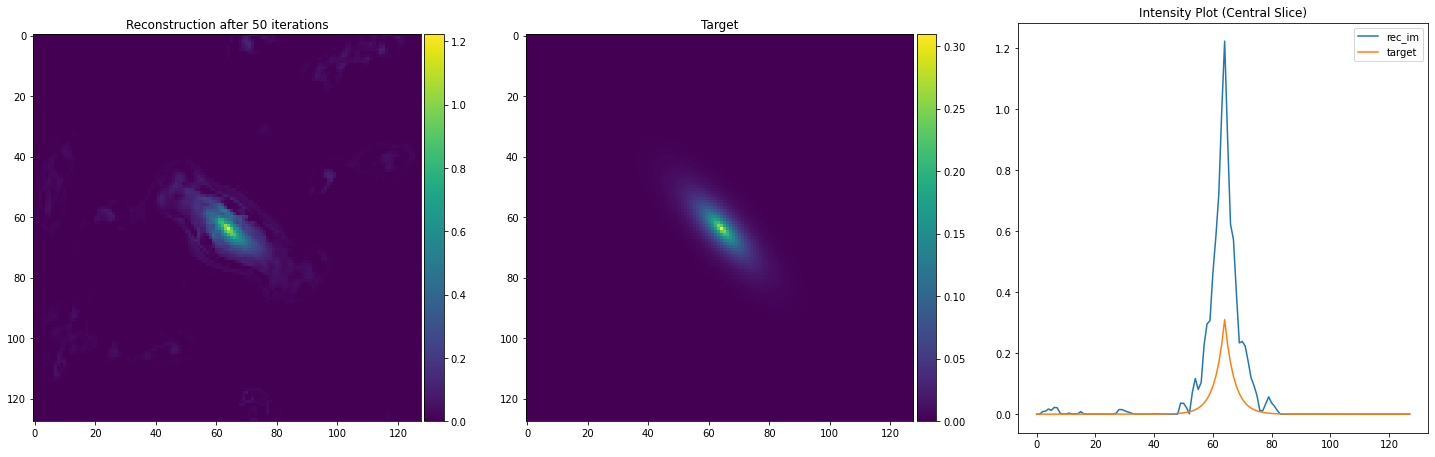

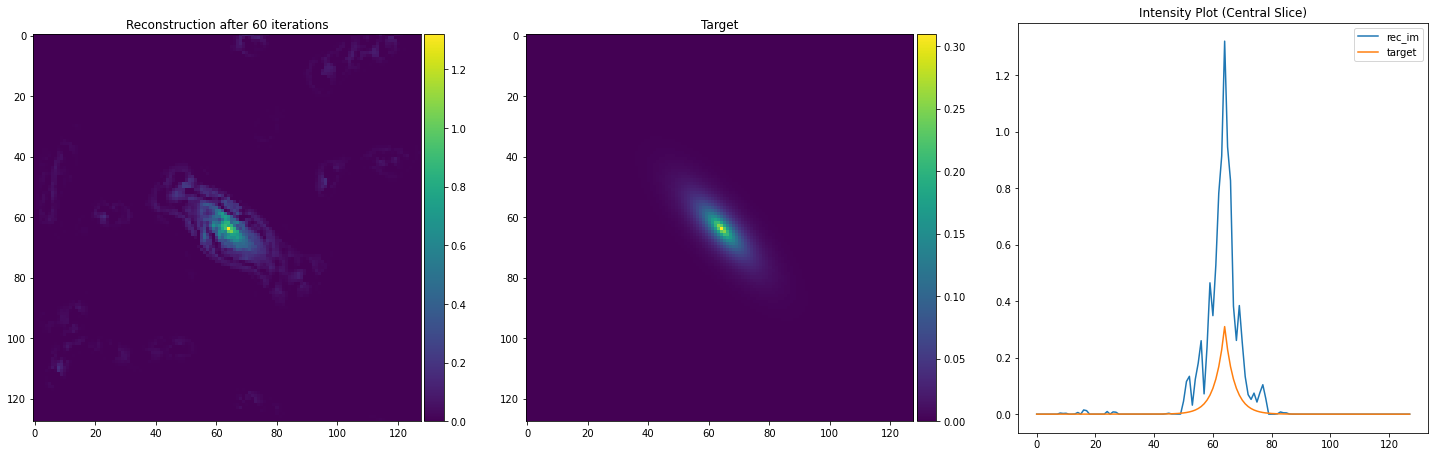

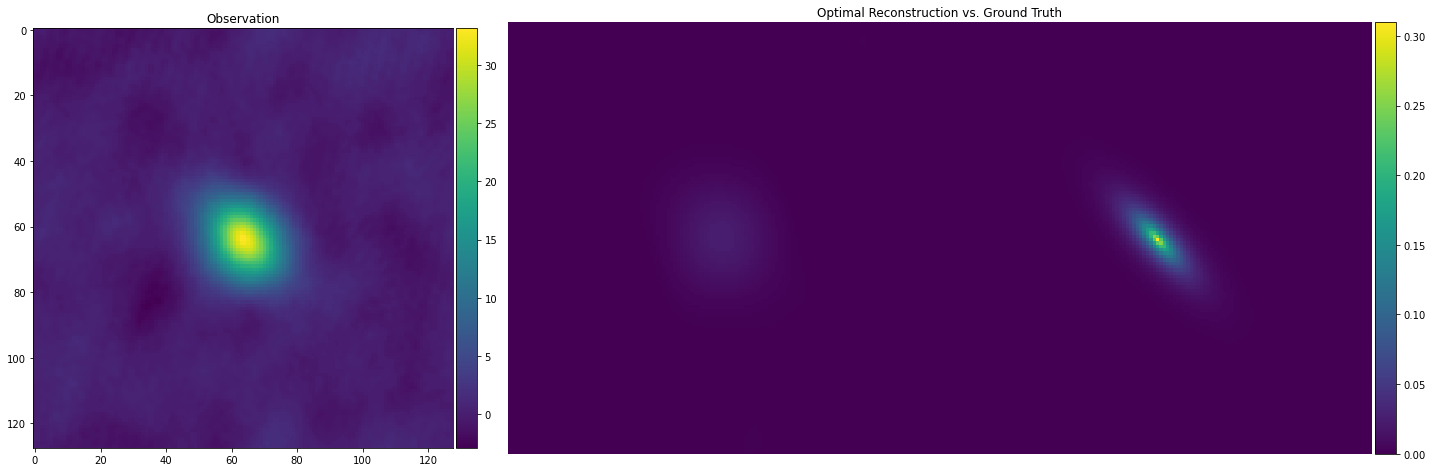

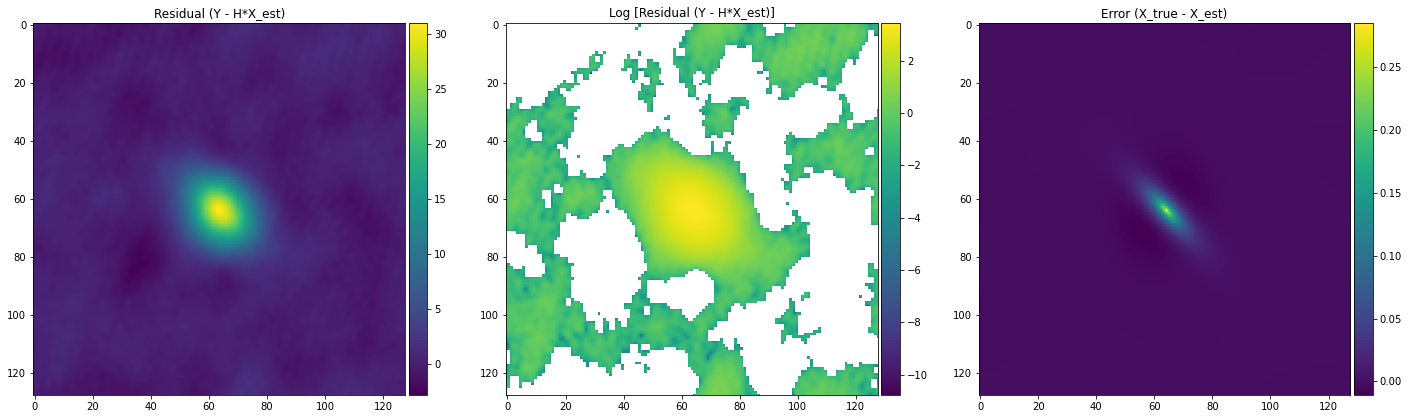

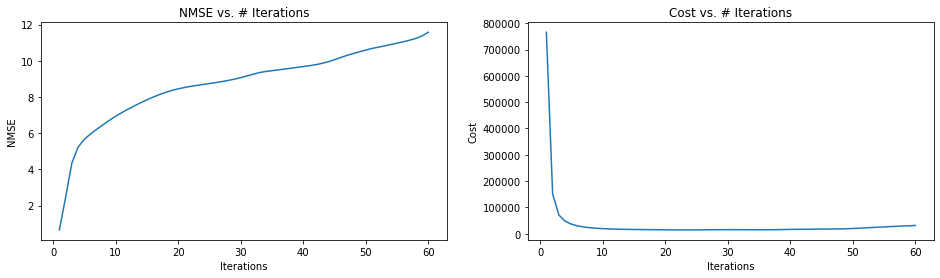


Minimum NMSE = 0.6546218395233154 (at [1] iterations)
Minimum Cost = 14295.8525390625 (at [23] iterations)


In [13]:
n_iter = 60
disp_step = 10

# ADMM parameters (initial)
x_0 = np.zeros(batch[0][0][0].shape)
z_0 = np.zeros(batch[0][0][0].shape)
mu_0 = 0.0                              
rho_0 = 500.0                    # Augmented lagrangian hyperparameter
rho_max = 2000.0                 # max rho value
eta = 0.5                        # should be between - [0, 1)
gamma = 1.4                      # multiplicative rho factor -- Should be > 1

x_opt = {}                       # Dictionary storing optimal reconstruction
cost = {}                        # Dictionary storing cost function
nmse_arr = {}                    # Dictionary storing NMSE


# Deconvolve given images
for gal_ind in [1600]:              # Loop over galaxies
    for SNR_ind in range(batch[3].shape[1]):
        
        print('\n\n Gal_ind = {} | SNR_ind = {}'.format(gal_ind, SNR_ind))
    
        gal_input = np.squeeze(batch[0][gal_ind,SNR_ind,...])
        gal_target = np.squeeze(batch[1][gal_ind])
        psf = batch[2][gal_ind]
        sigma_noise = np.std(gal_input[0:20,0:20])      # compute noise std. ona a slice of image excluding central blob
        SNR_D = np.max(gal_input) / sigma_noise         # SNR in direct space

        # Plot input, target & psf 
        plot_utils.plot_gal_psf_radio(gal_input, gal_target, psf, sigma_noise, SNR_D)

        # Cast numpy arrays to tensors
        gal_input_tf = tf.cast(gal_input, tf.float32)
        psf_tf = tf.cast(psf, tf.float32) 
        gal_target_tf = tf.cast(gal_target, tf.float32)

        # Deconvolve the image
        x_opt["{}_{}".format(gal_ind,SNR_ind)], cost["{}_{}".format(gal_ind,SNR_ind)], nmse_arr["{}_{}".format(gal_ind,SNR_ind)] = runADMM(gal_input_tf, x_0, psf_tf, grad, z_0, mu_0, 
                                                                                                                                           rho_0, rho_max, eta, gamma, sigma_noise, 
                                                                                                                                           disp_step, n_iter, model_1)
        # Visual Comparison
        plot_utils.comparison(x_opt["{}_{}".format(gal_ind,SNR_ind)], gal_target_tf, gal_input_tf, psf_tf, fftconvolve)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr["{}_{}".format(gal_ind,SNR_ind)], cost["{}_{}".format(gal_ind,SNR_ind)], n_iter)